In [1]:
import numpy as np
import h5py

import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize,
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
import plotter
import utils
import emulator
from chain_variables import *

In [2]:
color_glam = 'magenta'
color_aemulus = 'blue'
color_emuperf = 'green'

In [3]:
L_glam = 1000.
L_aemulus = 1050.

In [4]:
def covfn_from_chaintag(chaintag):
    chain_fn = f'../chains/chains_{chaintag}.h5'
    cov_dir = '../../clust/covariances/'
    with h5py.File(chain_fn, 'r+') as f:

        statistics = f.attrs['statistic']
        traintags = f.attrs['traintag']
        testtags = f.attrs['testtag']
        errtags = f.attrs['errtag']
        stat_str = '_'.join(statistics)
        tags = f.attrs['tag']
        nstats = len(statistics)
        acctags = [None]*nstats
        for i, statistic in enumerate(statistics):
            gptag = traintags[i] + errtags[i] + tags[i]
            acctags[i] = gptag + testtags[i]

        # If all tags the same, the tag string will just be that string
        if len(set(traintags))==1 and len(set(errtags))==1 and len(set(testtags))==1:
            tag_str = traintags[0] + errtags[0] + testtags[0]
        else:
            # Otherwise will need to join them all
            print("Using acctags joined for emu")
            tag_str.join(acctags)
            
        cov_emuperf_fn = f"{cov_dir}cov_emuperf_{stat_str}{tag_str}.dat"
        
    return cov_emuperf_fn

In [5]:
def get_cov(statistics, cov_tag, tag_str='', cov_dir='/home/users/ksf293/clust/covariances'):
    stat_str = '_'.join(statistics)
    cov_fn = f"{cov_dir}/cov_{cov_tag}_{stat_str}{tag_str}.dat"
    cov = np.loadtxt(cov_fn)
    return cov

In [6]:
def plot_correlation_matrix(corr, statistics):
    
    nstats = len(statistics)
    plt.figure(figsize=(2.5*nstats,2.5*nstats))
    tick_labels = np.concatenate([np.round(r_dict[stat], 2) for stat in statistics])
    im = plt.imshow(corr, origin='lower left', cmap='bwr_r', vmin=-1, vmax=1)
    plt.xticks(ticks=range(len(tick_labels)), labels=tick_labels, rotation=90)
    plt.yticks(ticks=range(len(tick_labels)), labels=tick_labels)

    # Label statistics
    for i, statistic in enumerate(statistics):
        plt.text(9*i+3.5, -6, statistic, fontsize=20)
        plt.text(-6, 9*i+3.5, statistic, fontsize=20, rotation=90)
        if i==0:
            continue
        plt.axvline(9*i-0.5, color='k')
        plt.axhline(9*i-0.5, color='k')

    plt.xlabel(r"r ($h^{-1}$Mpc)", labelpad=40)
    plt.ylabel(r"r ($h^{-1}$Mpc)", labelpad=40)

    plt.colorbar(im, fraction=0.046, pad=0.04)

In [7]:
def plot_icov_matrix(icov, statistics):
    
    nstats = len(statistics)
    plt.figure(figsize=(2.5*nstats,2.5*nstats))
    tick_labels = np.concatenate([np.round(r_dict[stat], 2) for stat in statistics])
    
    #absmax = np.max([np.max(icov), -np.min(icov)])
    #im = plt.imshow(icov, origin='lower left', cmap='bwr_r'), vmin=-absmax, vmax=absmax)
    
    orig_cmap = matplotlib.cm.bwr_r
    datarange = np.max(icov) - np.min(icov)
    zeropoint = np.abs(np.min(icov))/datarange
    shifted_cmap = shiftedColorMap(orig_cmap, midpoint=zeropoint, name='shifted')
    im = plt.imshow(icov, origin='lower left', cmap=shifted_cmap)

    plt.xticks(ticks=range(len(tick_labels)), labels=tick_labels, rotation=90)
    plt.yticks(ticks=range(len(tick_labels)), labels=tick_labels)

    # Label statistics
    for i, statistic in enumerate(statistics):
        plt.text(9*i+3.5, -6, statistic, fontsize=20)
        plt.text(-6, 9*i+3.5, statistic, fontsize=20, rotation=90)
        if i==0:
            continue
        plt.axvline(9*i-0.5, color='k')
        plt.axhline(9*i-0.5, color='k')

    plt.xlabel(r"r ($h^{-1}$Mpc)", labelpad=40)
    plt.ylabel(r"r ($h^{-1}$Mpc)", labelpad=40)

    plt.colorbar(im, fraction=0.046, pad=0.04)

In [8]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }
    
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [9]:
def plot_diagonal_covariance(statistics, covs, colors, labels, nbins=9, plot_stdev=False, show_legend=True):

    for i, cov in enumerate(covs):
        csize = nbins*len(statistics)
        assert (cov.shape[0]==csize) & (cov.shape[1]==csize), f'Covariance matrix {i} is wrong shape!'
    
    for s, statistic in enumerate(statistics):
        plt.figure(figsize=(8,6))
        ax = plt.gca()
        start = s*nbins
        end = (s+1)*nbins
        for i, cov in enumerate(covs):
            var = np.diag(cov)[start:end]
            ls = '-'
            if '{perf' in labels[i].split(' ')[0]:
                ls = '--'
            elif '{emu' in labels[i].split(' ')[0]:
                ls = ':'
                
            if plot_stdev:
                ax.plot(r_dict[statistic], np.sqrt(var), color=colors[i], label=labels[i], lw=1.5, ls=ls)
                ax.set_ylabel(r"standard deviation $\sigma$")
            else:
                ax.plot(r_dict[statistic], var, color=colors[i], label=labels[i], lw=1.5, ls=ls)
                ax.set_ylabel(r"variance $\sigma^2$")

        ax.set_title(statistic)
        ax.set_xlabel(r"r ($h^{-1}$Mpc)")
        ax.set_xscale(scale_dict[statistic][0])
        ax.set_yscale(scale_dict[statistic][1])
        if show_legend:
            ax.legend()

In [10]:
statistics_all = ['wp', 'xi', 'upf', 'mcf']

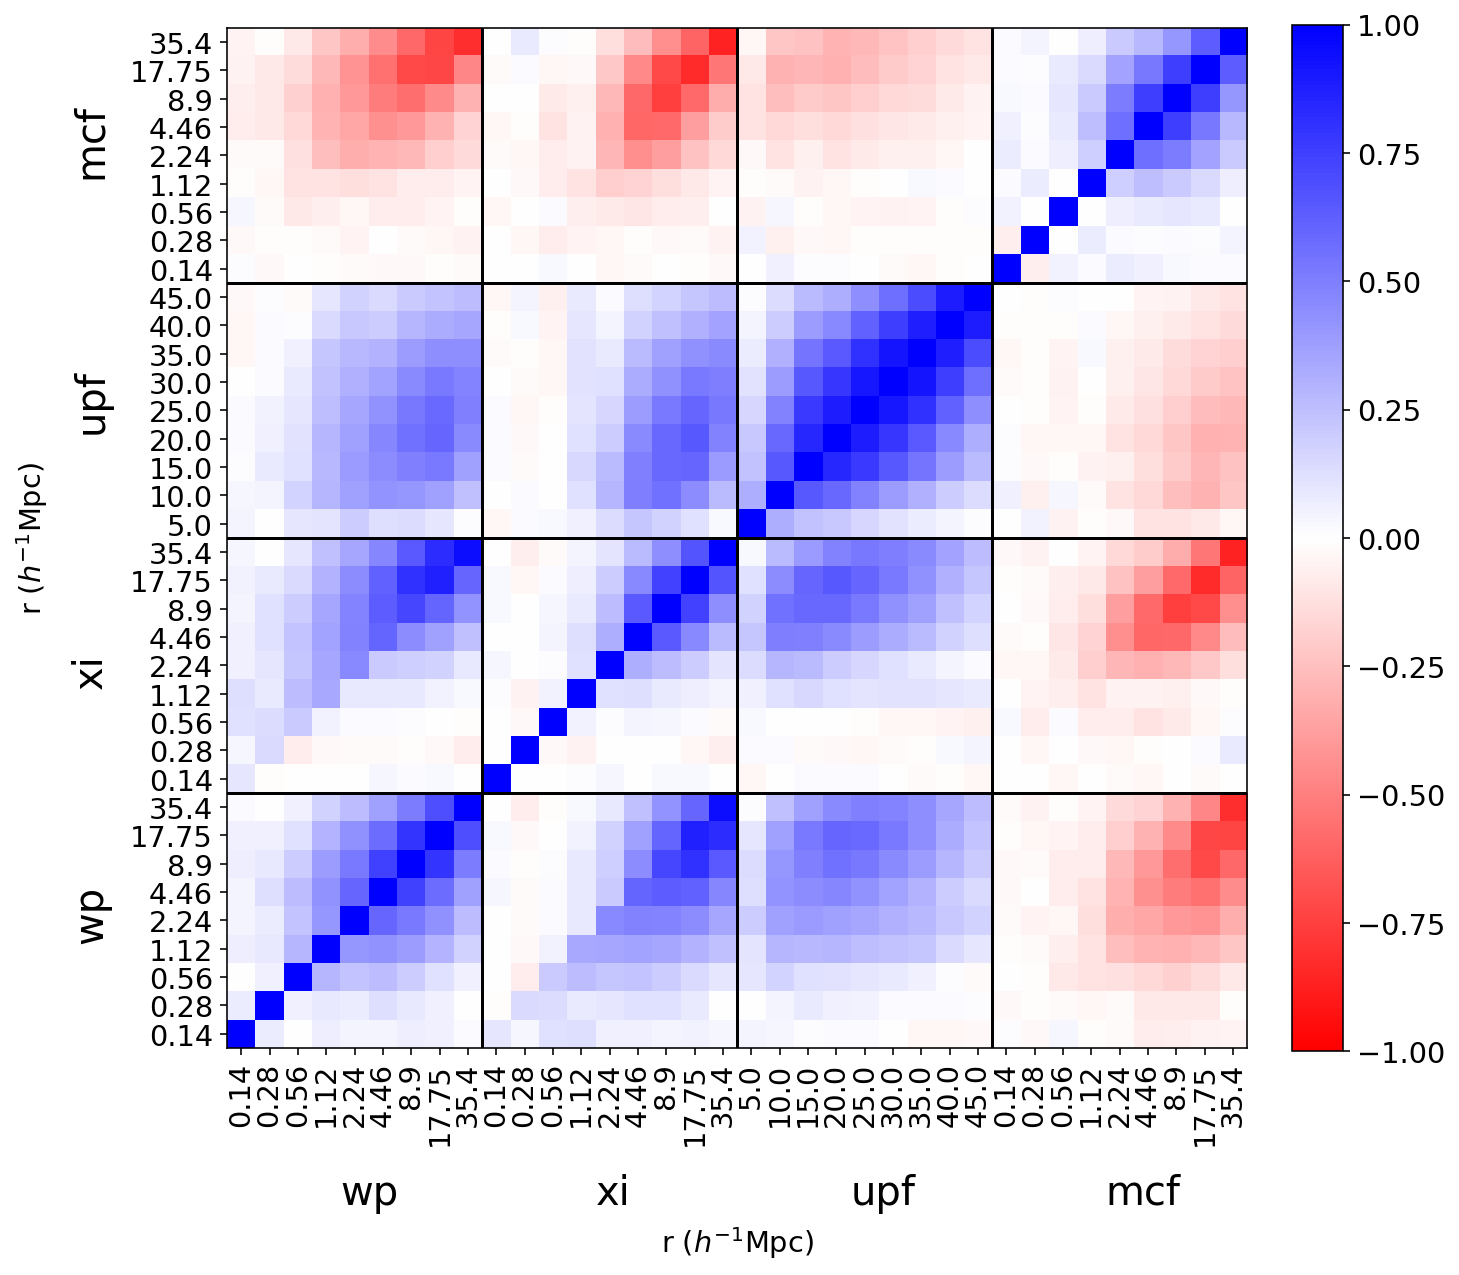

In [11]:
cov_glam = get_cov(statistics_all, 'glam')
corr_glam = utils.reduced_covariance(cov_glam)
plot_correlation_matrix(corr_glam, statistics_all)

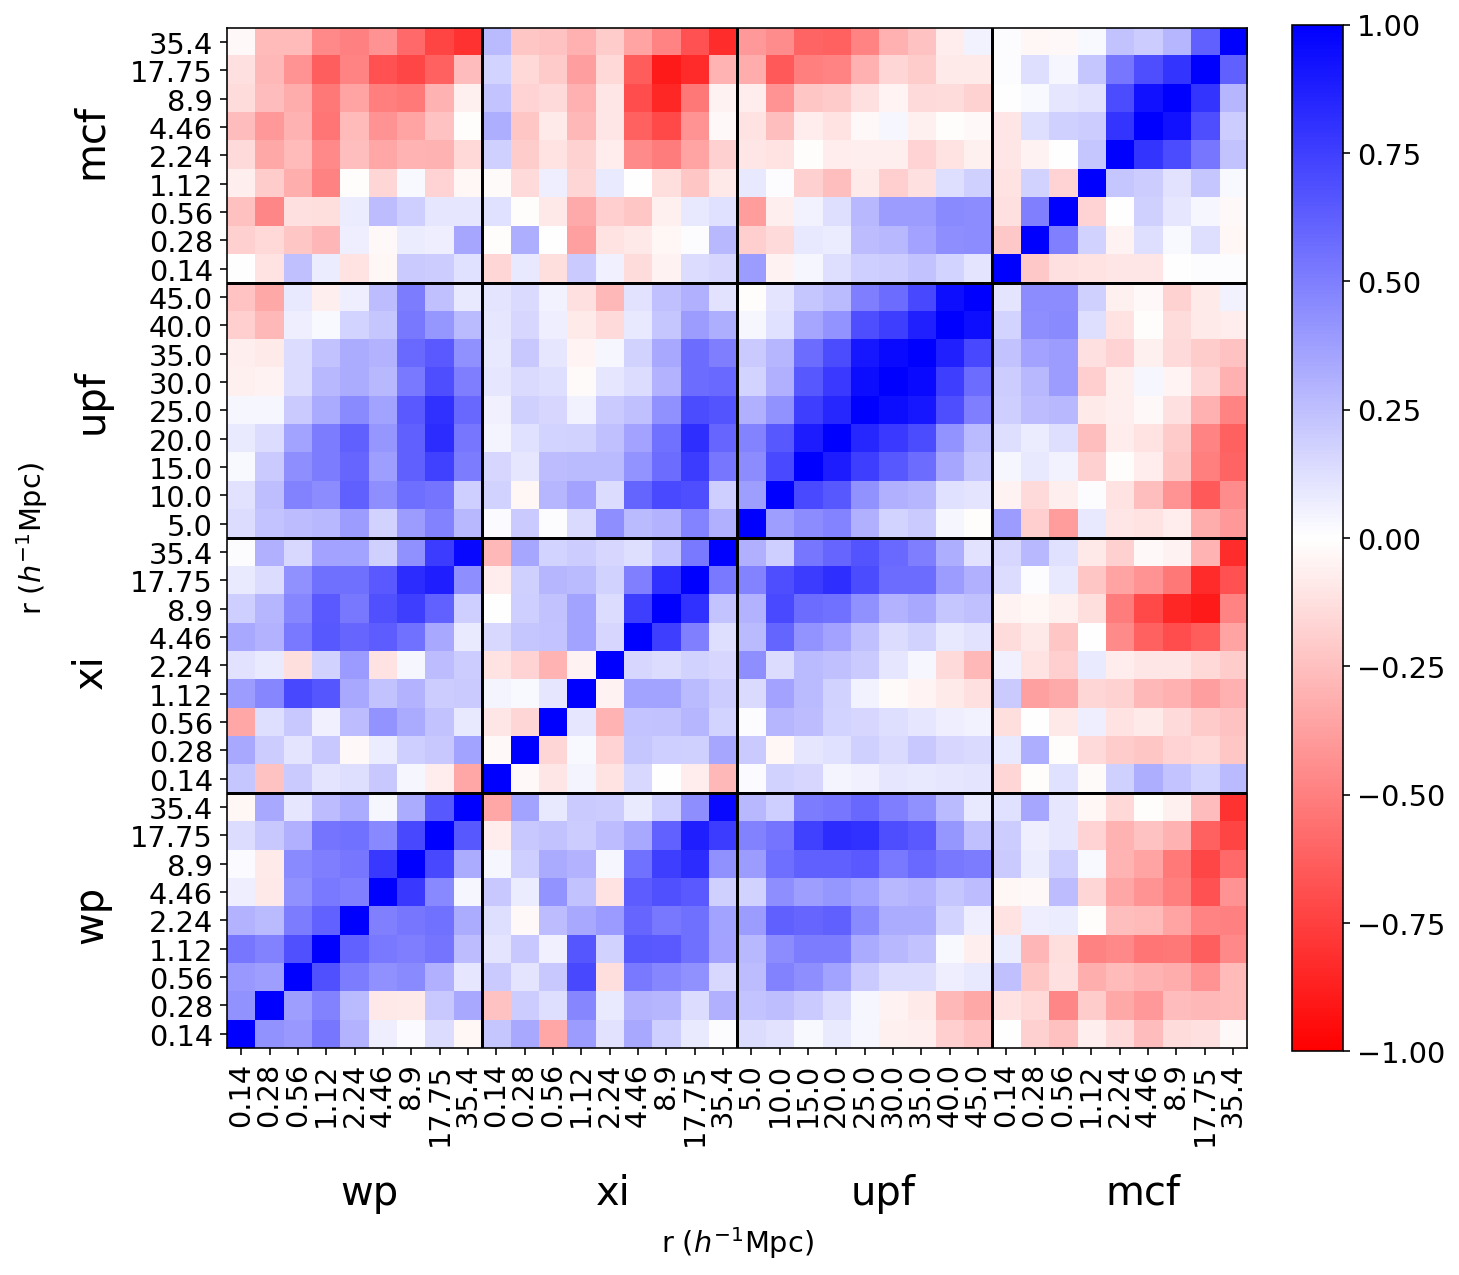

In [12]:
cov_aemulus = get_cov(statistics_all, 'aemulus', tag_str='_hod3_test0')
corr_aemulus = utils.reduced_covariance(cov_aemulus)
plot_correlation_matrix(corr_aemulus, statistics_all)

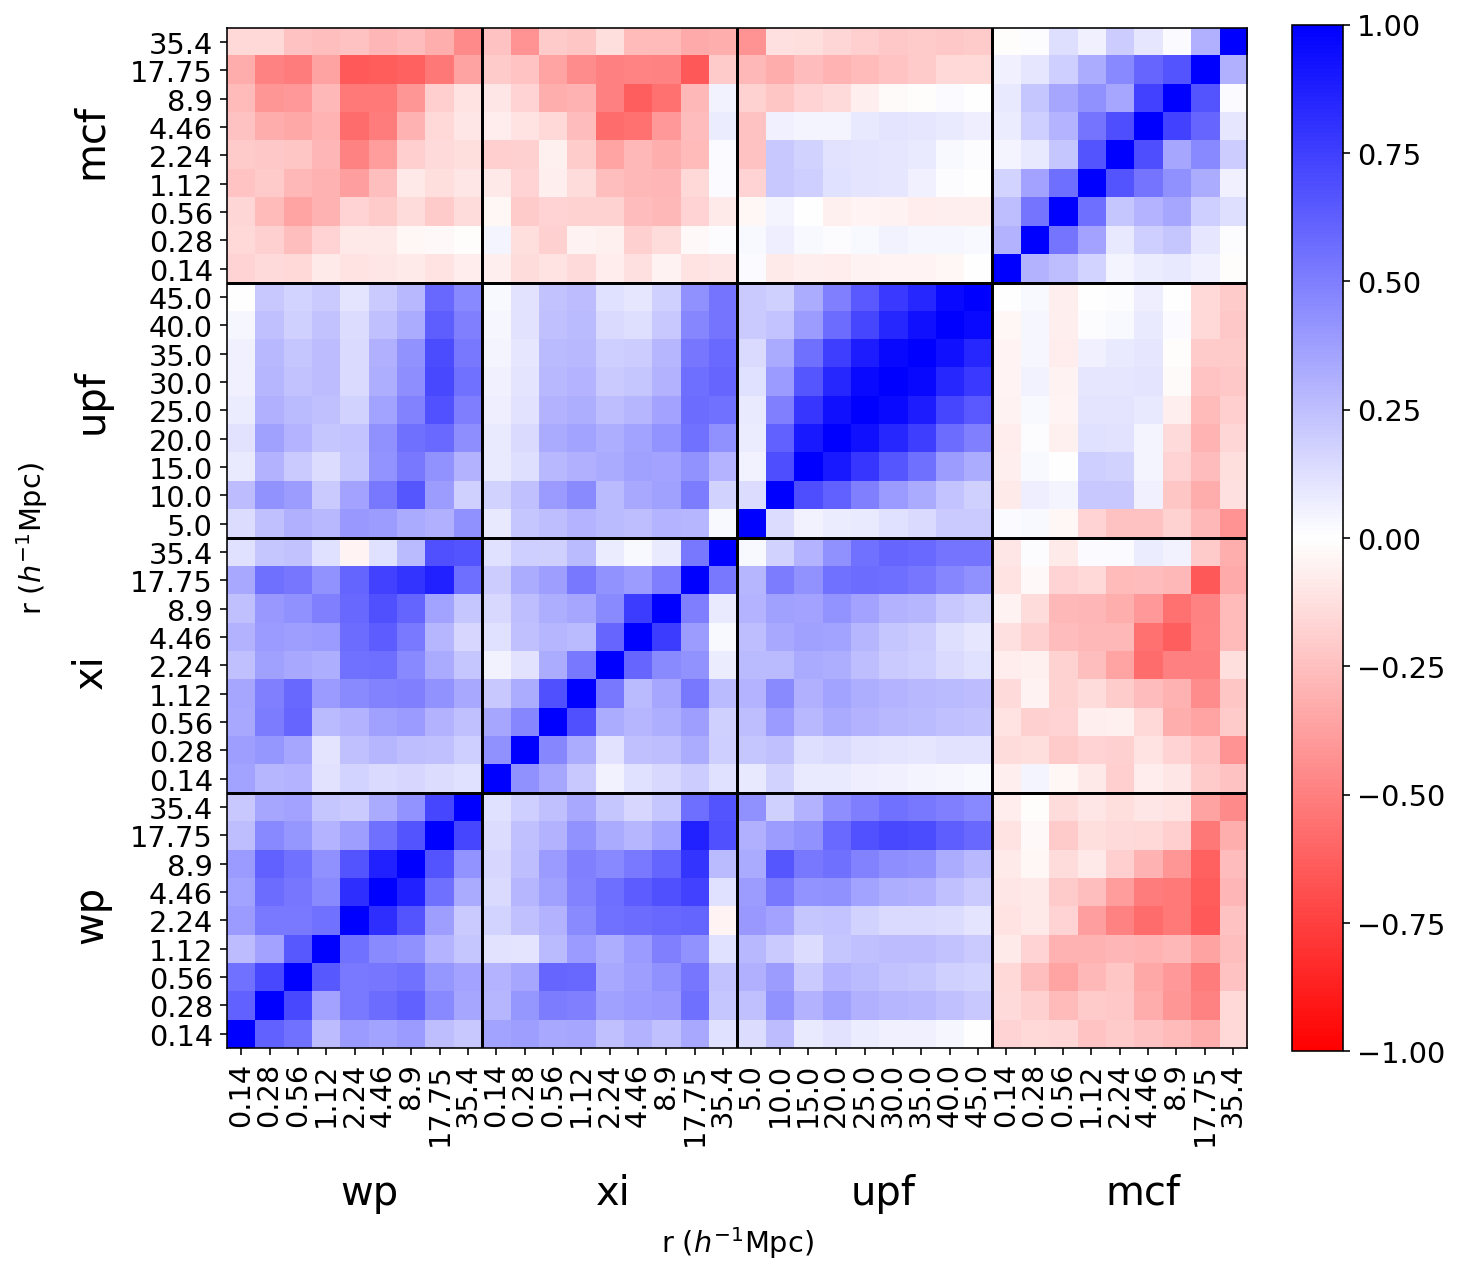

In [13]:
cov_emuperf = get_cov(statistics_all, 'emuperf', tag_str='_nonolap_hod3_test0_mean_test0')
corr_emuperf = utils.reduced_covariance(cov_emuperf)
plot_correlation_matrix(corr_emuperf, statistics_all)

In [14]:
cov_glam_scaled = cov_glam*(1/5)*(L_glam/L_aemulus)**3
cov_aemulus_5box = cov_aemulus*(1/5)

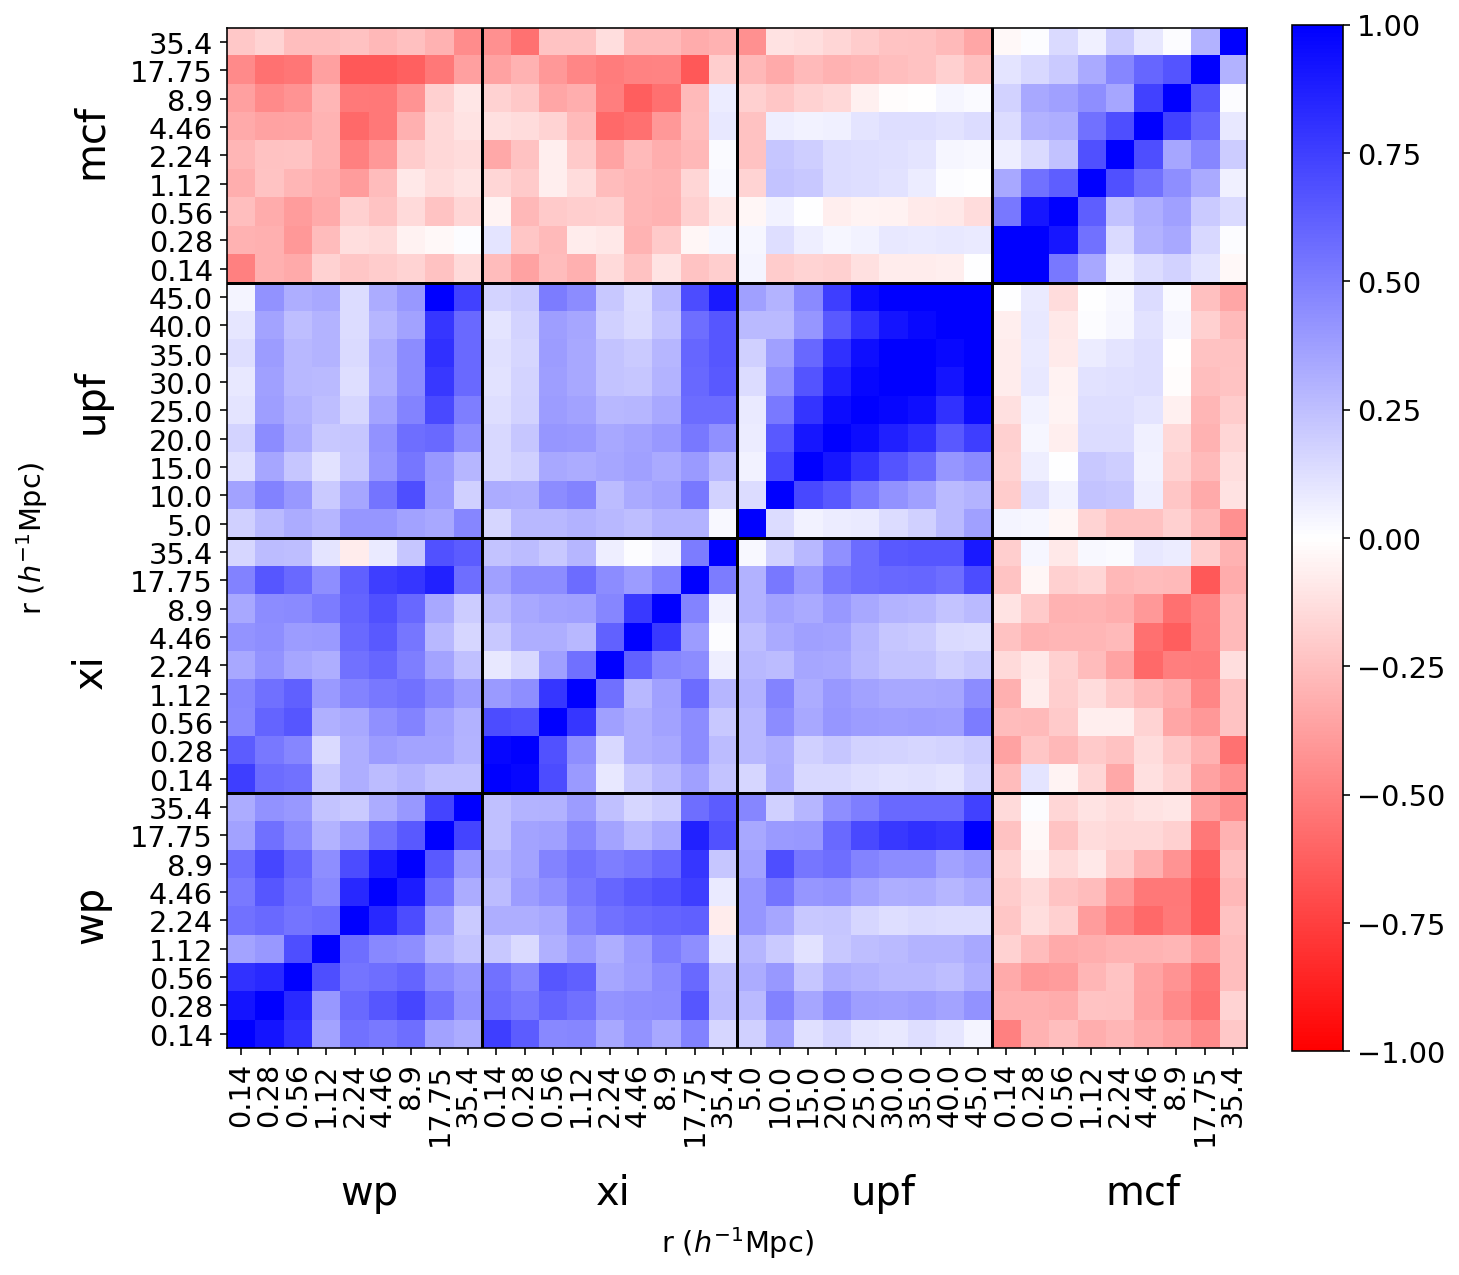

In [15]:
cov_emu = cov_emuperf - cov_glam_scaled
corr_emu = utils.reduced_covariance(cov_emu)
plot_correlation_matrix(corr_emu, statistics_all)

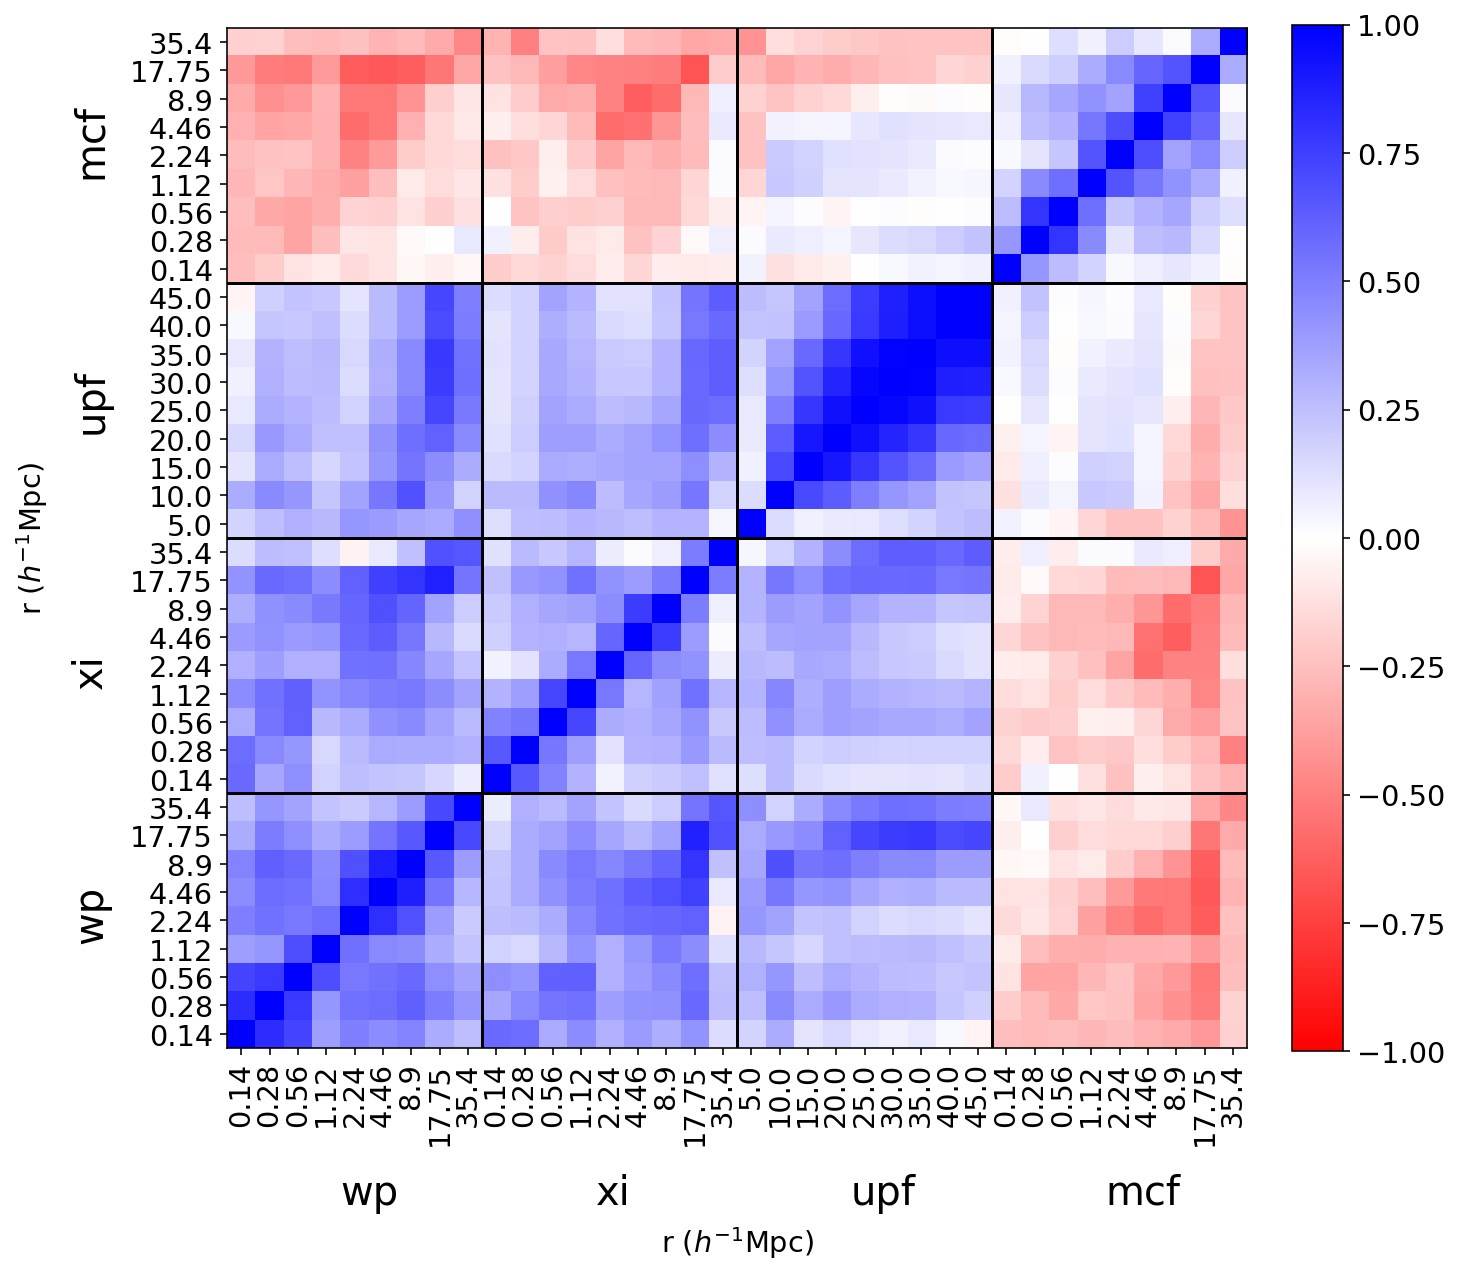

In [16]:
cov_likelihood = cov_emu + cov_aemulus_5box #??
corr_likelihood = utils.reduced_covariance(cov_likelihood)
plot_correlation_matrix(corr_likelihood, statistics_all)

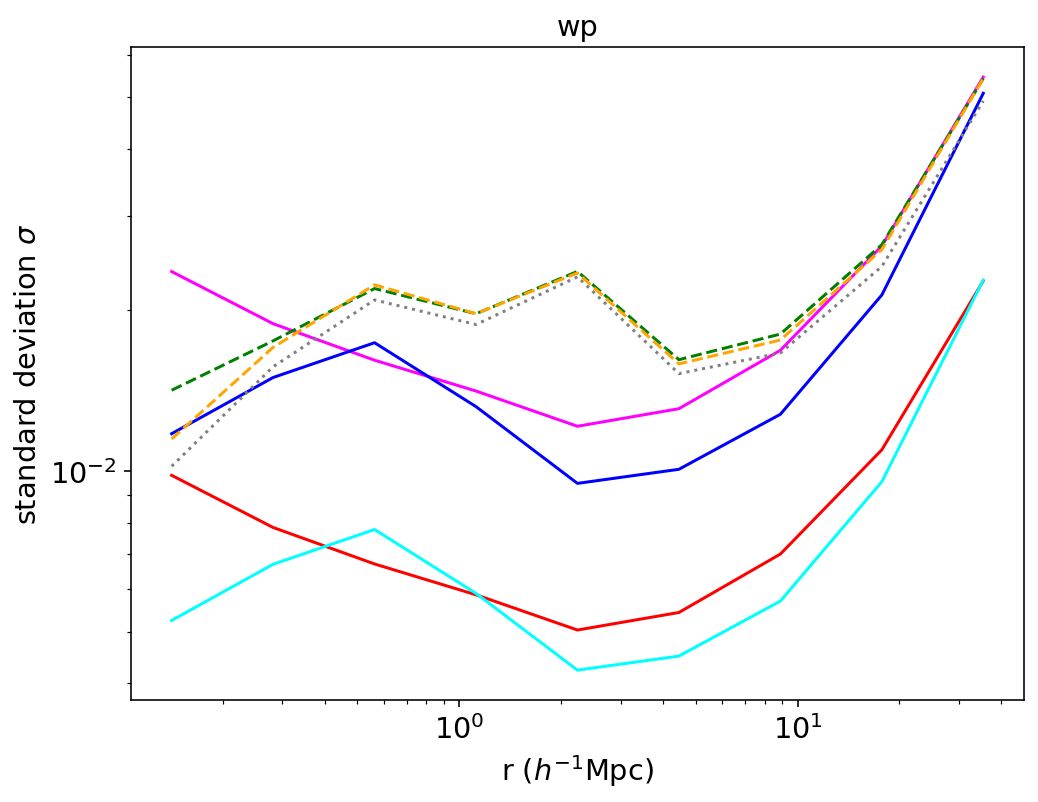

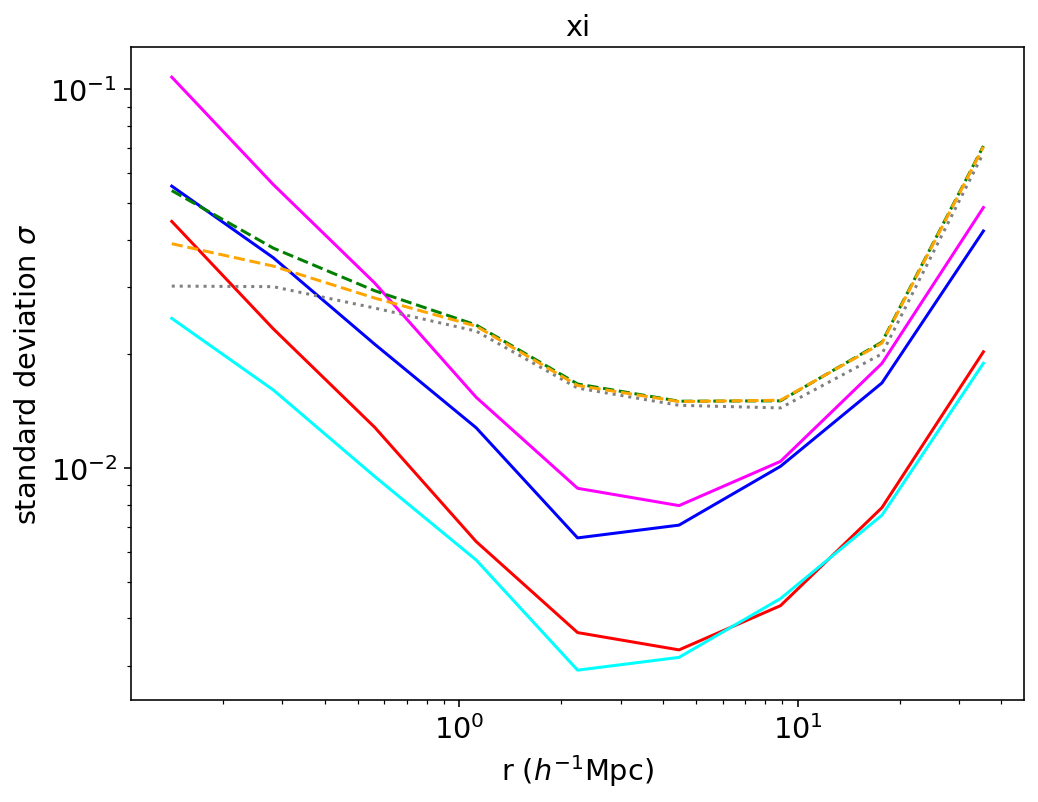

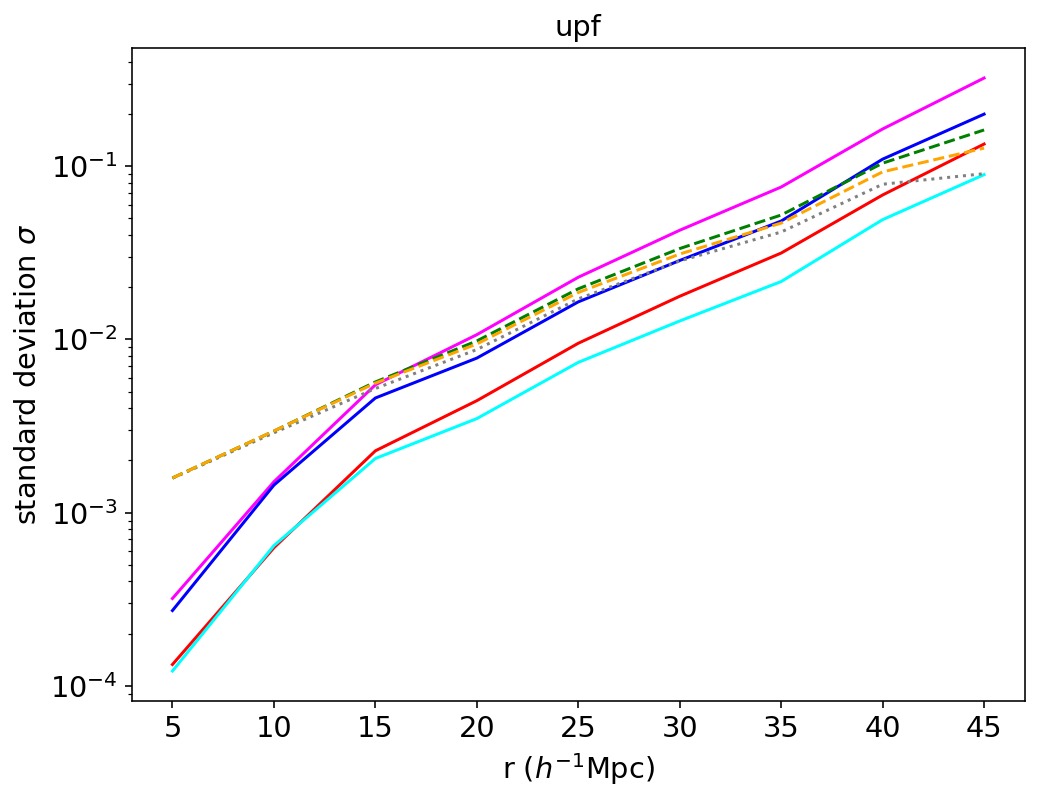

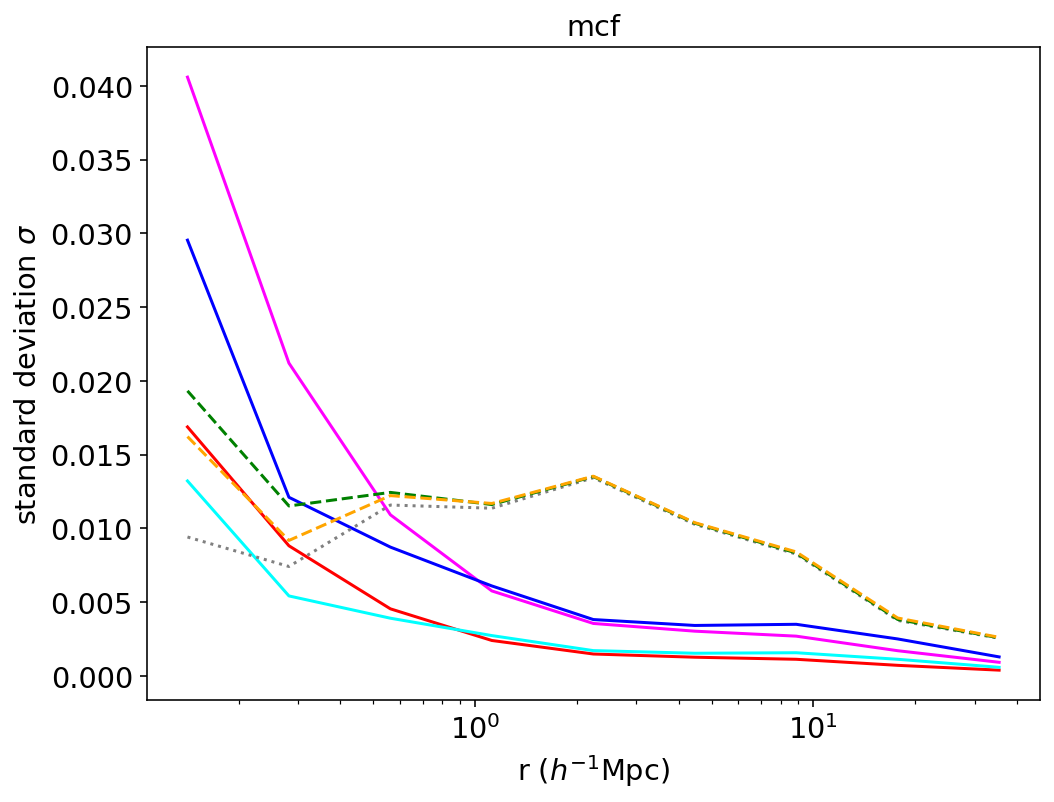

In [17]:
covs = [cov_glam, cov_glam_scaled, cov_aemulus, cov_aemulus_5box, cov_emu, cov_emuperf, cov_likelihood]
colors = [color_glam, 'red', color_aemulus, 'cyan', 'grey', color_emuperf, 'orange']
labels = [r'$C_\mathrm{test,GLAM}$', 
          r'$C_\mathrm{test,GLAMscaled}$', 
          r'$C_\mathrm{test,Aemulus1Box}$', 
          r'$C_\mathrm{test,Aemulus5Box}$',
          r'$C_\mathrm{emu} = C_\mathrm{perf,Aemulus5Box} - C_\mathrm{test,GLAMscaled}$',
          r'$C_\mathrm{perf,Aemulus5Box}$',
          r'$C_\mathrm{perf,GLAM} = C_\mathrm{emu} + C_\mathrm{test,Aemulus5Box}$']
plot_diagonal_covariance(statistics_all,
                         covs, 
                         colors,
                         labels,
                         plot_stdev=True,
                         show_legend=False)

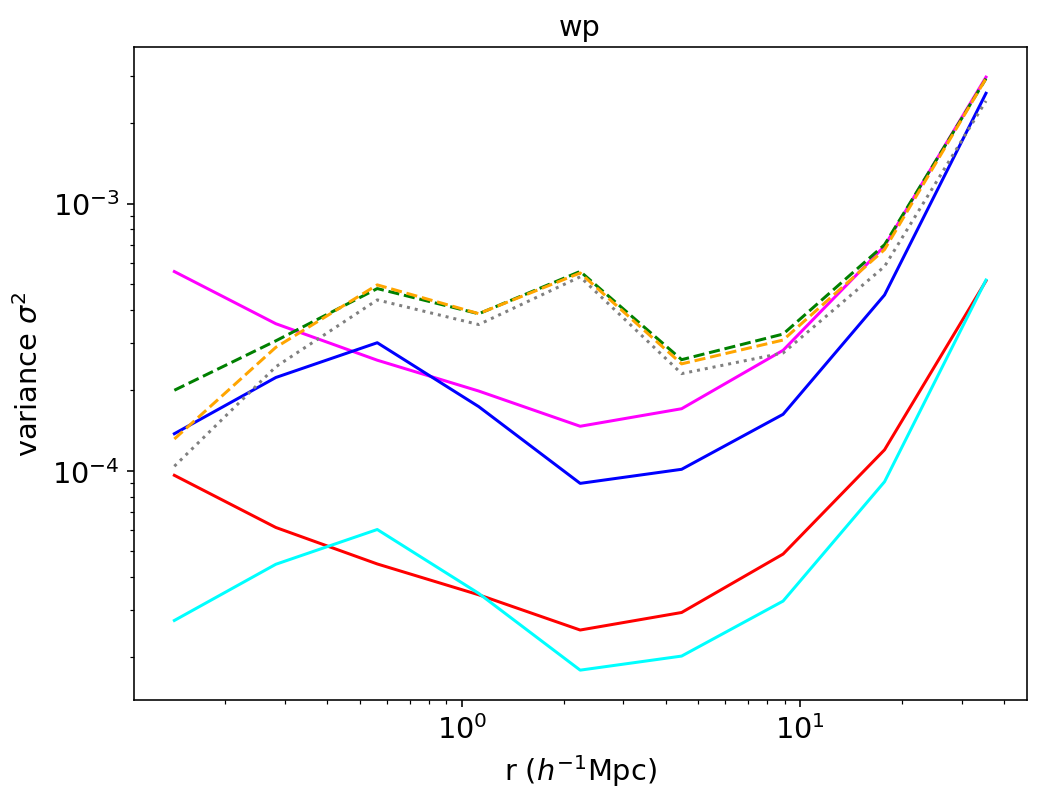

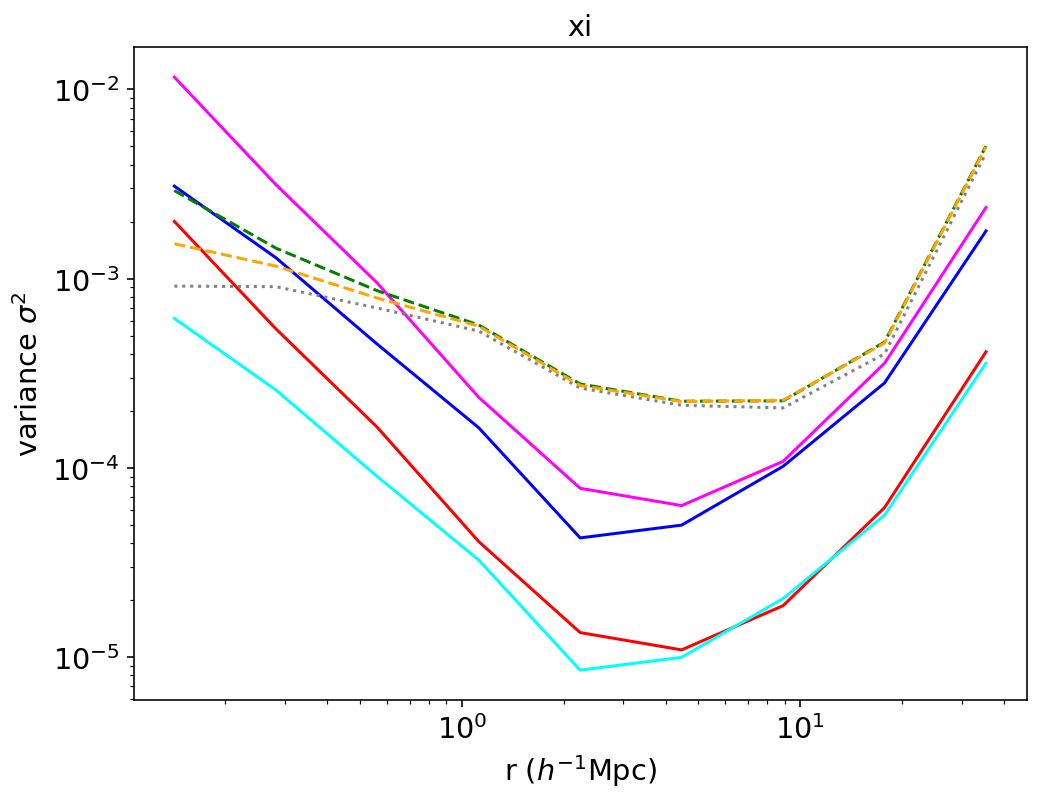

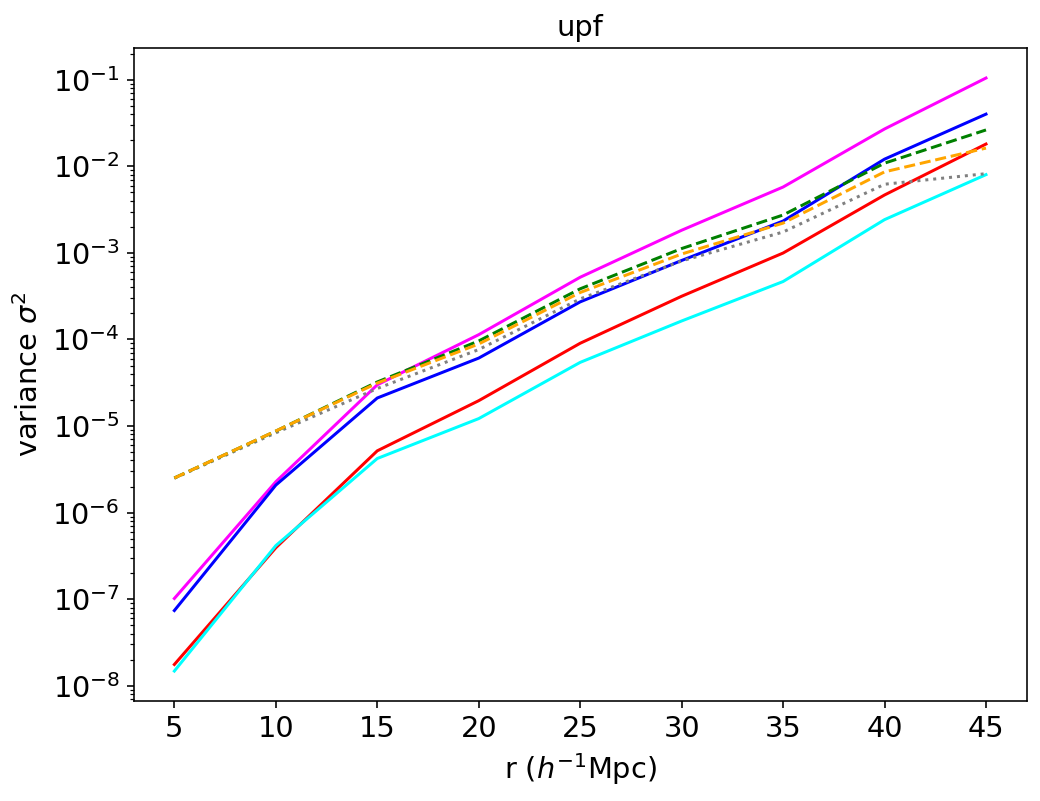

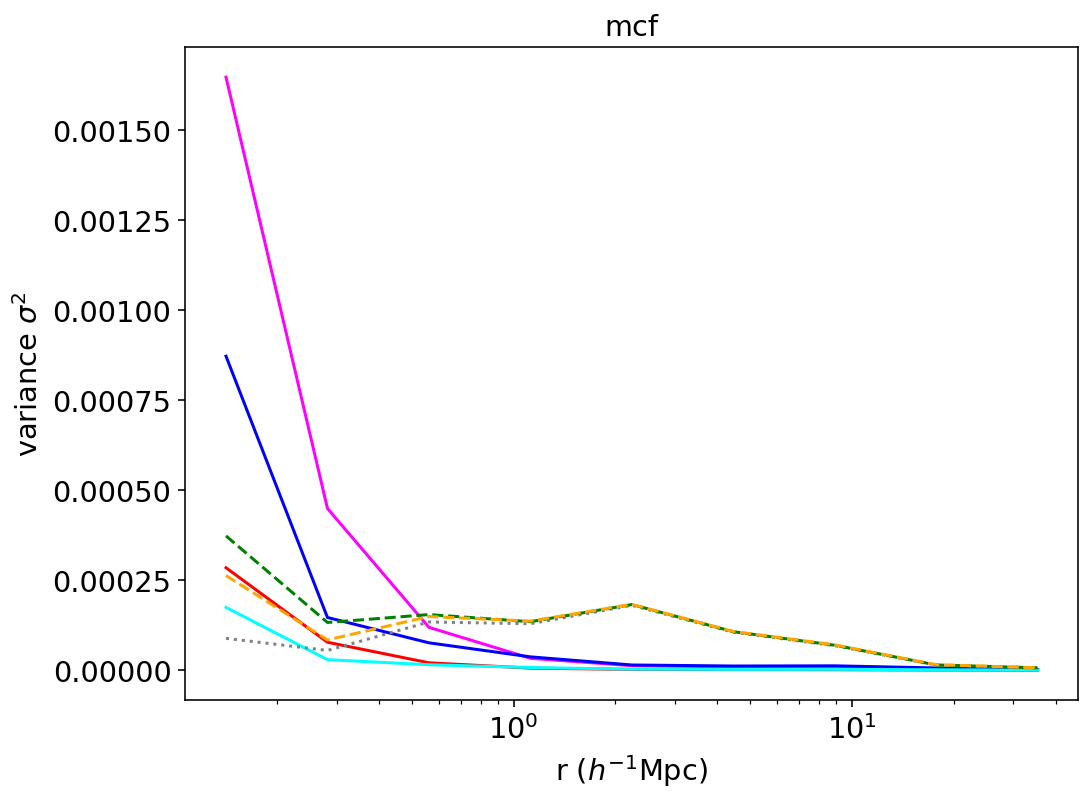

In [16]:
covs = [cov_glam, cov_glam_scaled, cov_aemulus, cov_aemulus_5box, cov_emu, cov_emuperf, cov_likelihood]
colors = [color_glam, 'red', color_aemulus, 'cyan', 'grey', color_emuperf, 'orange']
labels = [r'$C_\mathrm{test,GLAM}$', 
          r'$C_\mathrm{test,GLAMscaled}$', 
          r'$C_\mathrm{test,Aemulus1Box}$', 
          r'$C_\mathrm{test,Aemulus5Box}$',
          r'$C_\mathrm{emu} = C_\mathrm{perf,Aemulus5Box} - C_\mathrm{test,GLAMscaled}$',
          r'$C_\mathrm{perf,Aemulus5Box}$',
          r'$C_\mathrm{perf,GLAM} = C_\mathrm{emu} + C_\mathrm{test,Aemulus5Box}$']
plot_diagonal_covariance(statistics_all,
                         covs, 
                         colors,
                         labels,
                         plot_stdev=False,
                         show_legend=False)

## Check condition numbers

In [51]:
print(1./np.linalg.cond(cov_aemulus))
print(1./np.linalg.cond(cov_aemulus_5box))
print(1./np.linalg.cond(cov_glam))
print(1./np.linalg.cond(cov_emuperf))

3.0082957537794405e-20
5.319658613737054e-21
6.487693265485251e-07
2.5143223625399204e-05


In [48]:
cov_emuperf_w = get_cov(['wp'], 'emuperf', tag_str='_nonolap_hod3_test0_mean_test0')
print(1./np.linalg.cond(cov_emuperf_w))
cov_emuperf_wx = get_cov(['wp', 'xi'], 'emuperf', tag_str='_nonolap_hod3_test0_mean_test0')
print(1./np.linalg.cond(cov_emuperf_wx))
cov_emuperf_wxu = get_cov(['wp', 'xi', 'upf'], 'emuperf', tag_str='_nonolap_hod3_test0_mean_test0')
print(1./np.linalg.cond(cov_emuperf_wxu))
cov_emuperf_wxum = get_cov(['wp', 'xi', 'upf', 'mcf'], 'emuperf', tag_str='_nonolap_hod3_test0_mean_test0')
print(1./np.linalg.cond(cov_emuperf_wxum))

0.006960826642745742
0.0029448005060714803
3.051073462031662e-05
2.5143223625399204e-05


In [49]:
cov_glam_w = get_cov(['wp'], 'glam')
print(1./np.linalg.cond(cov_glam_w))
cov_glam_wx = get_cov(['wp', 'xi'], 'glam')
print(1./np.linalg.cond(cov_glam_wx))
cov_glam_wxu = get_cov(['wp', 'xi', 'upf'], 'glam')
print(1./np.linalg.cond(cov_glam_wxu))
cov_glam_wxum = get_cov(['wp', 'xi', 'upf', 'mcf'], 'glam')
print(1./np.linalg.cond(cov_glam_wxum))

0.011998391383506966
0.0015349740468683277
6.648243079806474e-07
6.487693265485251e-07


In [50]:
cov_aemulus_w = get_cov(['wp'], 'aemulus', tag_str='_hod3_test0')
print(1./np.linalg.cond(cov_aemulus_w))
cov_aemulus_wx = get_cov(['wp', 'xi'], 'aemulus', tag_str='_hod3_test0')
print(1./np.linalg.cond(cov_aemulus_wx))
cov_aemulus_wxu = get_cov(['wp', 'xi', 'upf'], 'aemulus', tag_str='_hod3_test0')
print(1./np.linalg.cond(cov_aemulus_wxu))
cov_aemulus_wxum = get_cov(['wp', 'xi', 'upf', 'mcf'], 'aemulus', tag_str='_hod3_test0')
print(1./np.linalg.cond(cov_aemulus_wxum))

0.006250711514400252
0.0005074919944692167
4.3520492693581084e-08
3.0082957537794405e-20


In [43]:
cov_combined = get_cov(statistics_all, 'combined_glam')

[ 1.31443686e-04  1.61160533e-04  1.86779185e-04  8.45923406e-05
  1.36363570e-04  8.17509294e-05  9.63069795e-05  9.66019954e-05
  1.58194366e-04  2.62119956e-04  2.25121682e-04  1.08039219e-04
  1.22080976e-04  5.84750902e-05  6.77636951e-05  5.47287510e-05
  1.02104858e-04  1.12382354e-04  3.00643288e-06  1.09763022e-05
  6.71055421e-06  1.64056936e-05  1.99821982e-05  2.22927585e-05
  4.71029301e-05  2.58531922e-05 -6.56596692e-05 -4.73744905e-05
 -2.82466959e-05 -3.54013448e-05 -3.80355198e-05 -4.07609827e-05
 -3.66156699e-05 -3.23289744e-05 -1.80561757e-05 -5.58733672e-06]
[ 1.31443686e-04  1.61160533e-04  1.86779185e-04  8.45923406e-05
  1.36363570e-04  8.17509294e-05  9.63069795e-05  9.66019954e-05
  1.58194366e-04  2.62119956e-04  2.25121682e-04  1.08039219e-04
  1.22080976e-04  5.84750902e-05  6.77636951e-05  5.47287510e-05
  1.02104858e-04  1.12382354e-04  3.00643288e-06  1.09763022e-05
  6.71055421e-06  1.64056936e-05  1.99821982e-05  2.22927585e-05
  4.71029301e-05  2.5853

In [46]:
print(np.linalg.cond(cov_combined))
print(1./np.linalg.cond(cov_combined))

31044.798865324843
3.221151486076914e-05


In [ ]:
eigs = la.eig(cov_glam_w)[0]
k = la.norm(eigs-eigsp)/la.norm(perturb)    # Absolute condition number
print(k)
kr = k*la.norm(M)/la.norm(eigs)  # Relative condition number
print(kr)

## Eigendecompose emu cov matrix

Let's practice on just the wp emu covmat:

In [52]:
cov_emuperf_w = get_cov(['wp'], 'emuperf', tag_str='_nonolap_hod3_test0_mean_test0')
cov_glam_w = get_cov(['wp'], 'glam')
cov_glam_scaled_w = cov_glam_w*(1/5)*(L_glam/L_aemulus)**3
cov_emu_w = cov_emuperf_w - cov_glam_scaled_w

In [53]:
#print(cov_emu_w)

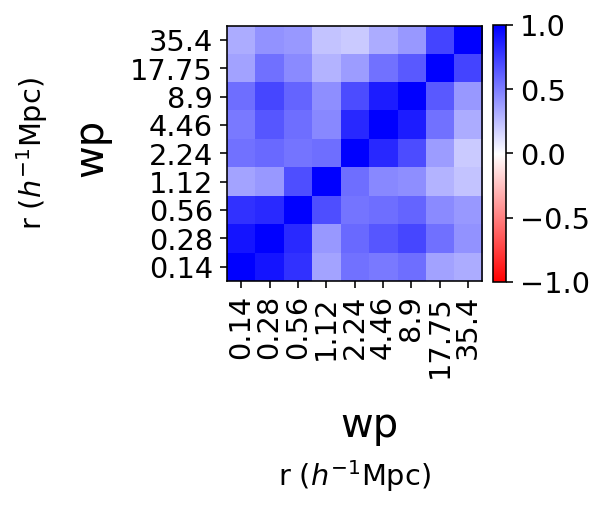

In [54]:
corr_emu_w = utils.reduced_covariance(cov_emu_w)
plot_correlation_matrix(corr_emu_w, ['wp'])

In [55]:
# recenter on zero (mean of columns)
#cov_emu_mean0_w = cov_emu_w - np.mean(cov_emu_w, axis=0)
#cov_emu_mean0_w -= np.mean(cov_emu_mean0_w, axis=1)
#assert np.all(np.mean(cov_emu_mean0_w, axis=
#print(np.mean(cov_emu_mean0_w, axis=0))
#print(cov_emu_mean0_w)

In [56]:
eigvals, eigvecs = np.linalg.eig(cov_emu_w)
print(eigvals)

[3.21753493e-03 1.10899062e-03 3.13497600e-04 2.27920467e-04
 1.78019071e-04 7.73008988e-05 6.43317065e-06 2.93775697e-05
 1.68755272e-05]


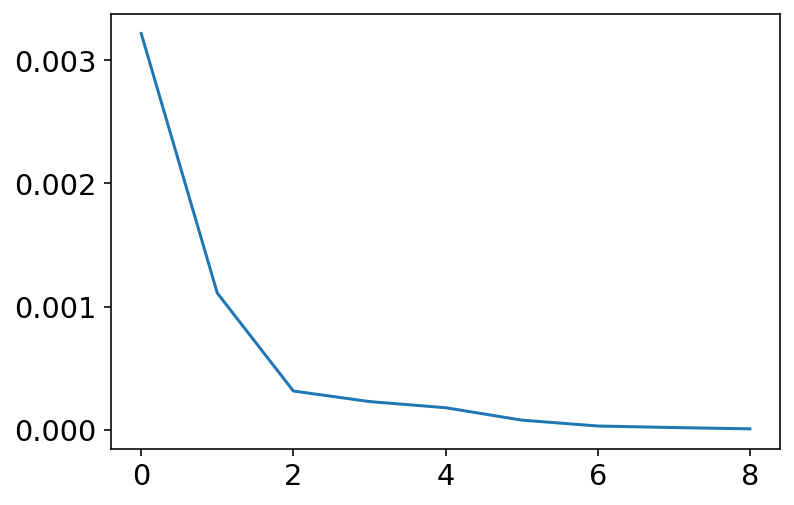

In [57]:
# plot eigenvalues
plt.plot(np.sort(eigvals)[::-1])

In [58]:
# cov mats are real symmetric, so can use the transpose instead of inverse 
cov_emu_decomposed = eigvecs @ np.diag(eigvals) @ eigvecs.T

In [61]:
#assert np.array_equal(cov_emu_decomposed, cov_emu), "Covs not equal!"
assert np.allclose(cov_emu_decomposed, cov_emu_w), "Covs not close!"

In [136]:
# The eigenvalues are not sorted! So find top ones.
n_largest = 4
idxs_largest = np.argpartition(eigvals, -n_largest)[-n_largest:]
idxs_largest = np.sort(idxs_largest)
print(idxs_largest)

[0 1 2 3]


In [137]:
eigvals_largest = [eigvals[i] if i in idxs_largest else 0 for i in range(len(eigvals))]   

In [140]:
cov_emu_largest_orig = eigvecs @ np.diag(eigvals_largest) @ eigvecs.T
#print(eigvecs[idxs_largest])
c = eigvecs[:,idxs_largest]
print(cov_emu_w.shape, c.shape)
w = cov_emu_w @ c
#print(w)
cov_emu_largest = w @ c.T
assert np.allclose(cov_emu_largest, cov_emu_largest_orig), "Covs not close!"
#assert np.allclose(cov_emu_largest, cov_emu_w), "Covs not close!"

(9, 9) (9, 4)


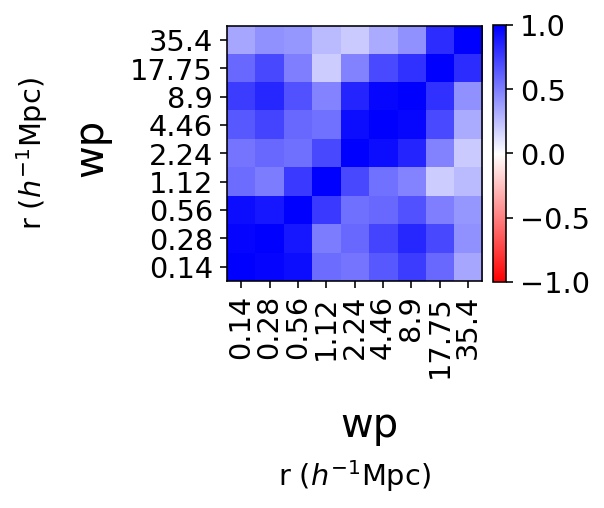

In [142]:
corr_emu_largest_orig = utils.reduced_covariance(cov_emu_largest_orig)
plot_correlation_matrix(corr_emu_largest_orig, ['wp'])

In [30]:
def plot_eigenvalues(cov):
    eigvals, eigvecs = np.linalg.eig(cov)
    plt.figure(figsize=(4,3))
    plt.plot(np.sort(eigvals)[::-1], marker='o', markersize=6)
    plt.xlabel("component")
    plt.ylabel(f"eigenvalue $\lambda$")
    return plt.gca()

In [31]:
def eigendecomp(cov, n_largest):
    eigvals, eigvecs = np.linalg.eig(cov)
    # The eigenvalues are not sorted! So find top ones.
    idxs_largest = np.argpartition(eigvals, -n_largest)[-n_largest:]
    idxs_largest = np.sort(idxs_largest)
    
    eigvals_largest = [eigvals[i] if i in idxs_largest else 0 for i in range(len(eigvals))] 
    cov_largest = eigvecs @ np.diag(eigvals_largest) @ eigvecs.T
    return cov_largest

In [32]:
# via http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/
def eigendecomp_v2(cov, n_largest):
    eigvals, eigvecs = np.linalg.eig(cov)
    # The eigenvalues are not sorted! So find top ones.
    idxs_largest = np.argpartition(eigvals, -n_largest)[-n_largest:]
    idxs_largest = np.sort(idxs_largest)
    
    c = eigvecs[:,idxs_largest]
    w = cov @ c
    cov_largest = w @ c.T
    return cov_largest

## aemulus wp

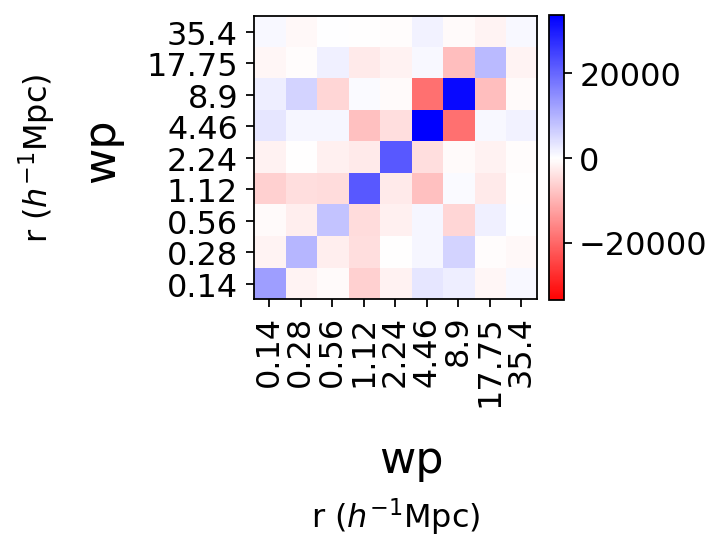

In [240]:
cov_aemulus_w = get_cov(['wp'], 'aemulus', tag_str='_hod3_test0')
icov_aemulus_w = np.linalg.inv(cov_aemulus_w)
#corr_aemulus_w = utils.reduced_covariance(cov_aemulus_w)
plot_icov_matrix(icov_aemulus_w, ['wp'])

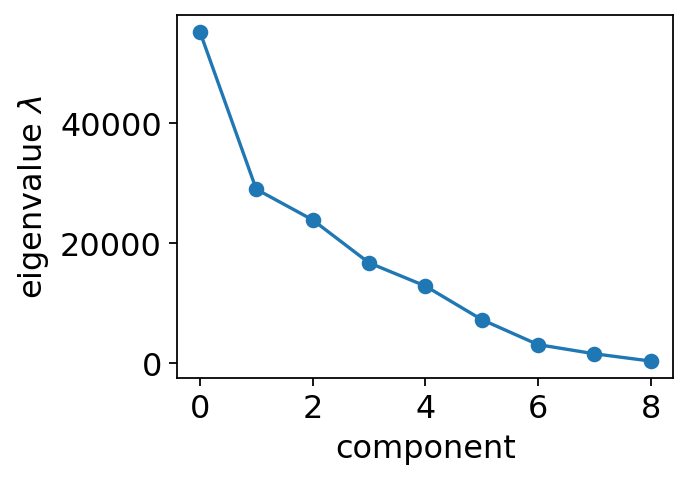

In [241]:
plot_eigenvalues(icov_aemulus_w)

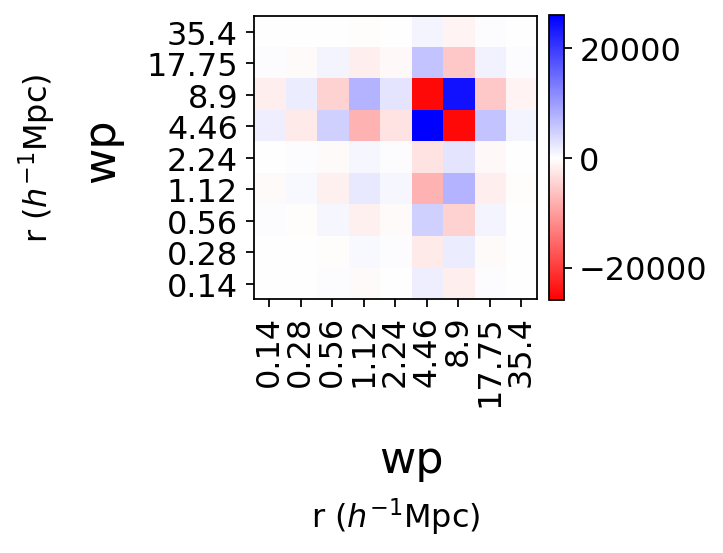

In [245]:
icov_aemulus_w_largest = eigendecomp_v2(icov_aemulus_w, 1)
plot_icov_matrix(icov_aemulus_w_largest, ['wp'])

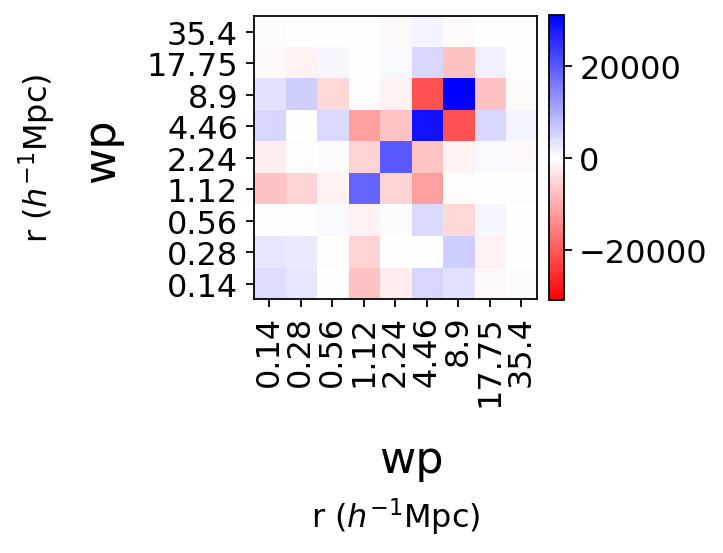

In [248]:
icov_aemulus_w_largest = eigendecomp_v2(icov_aemulus_w, 3)
plot_icov_matrix(icov_aemulus_w_largest, ['wp'])

### glam

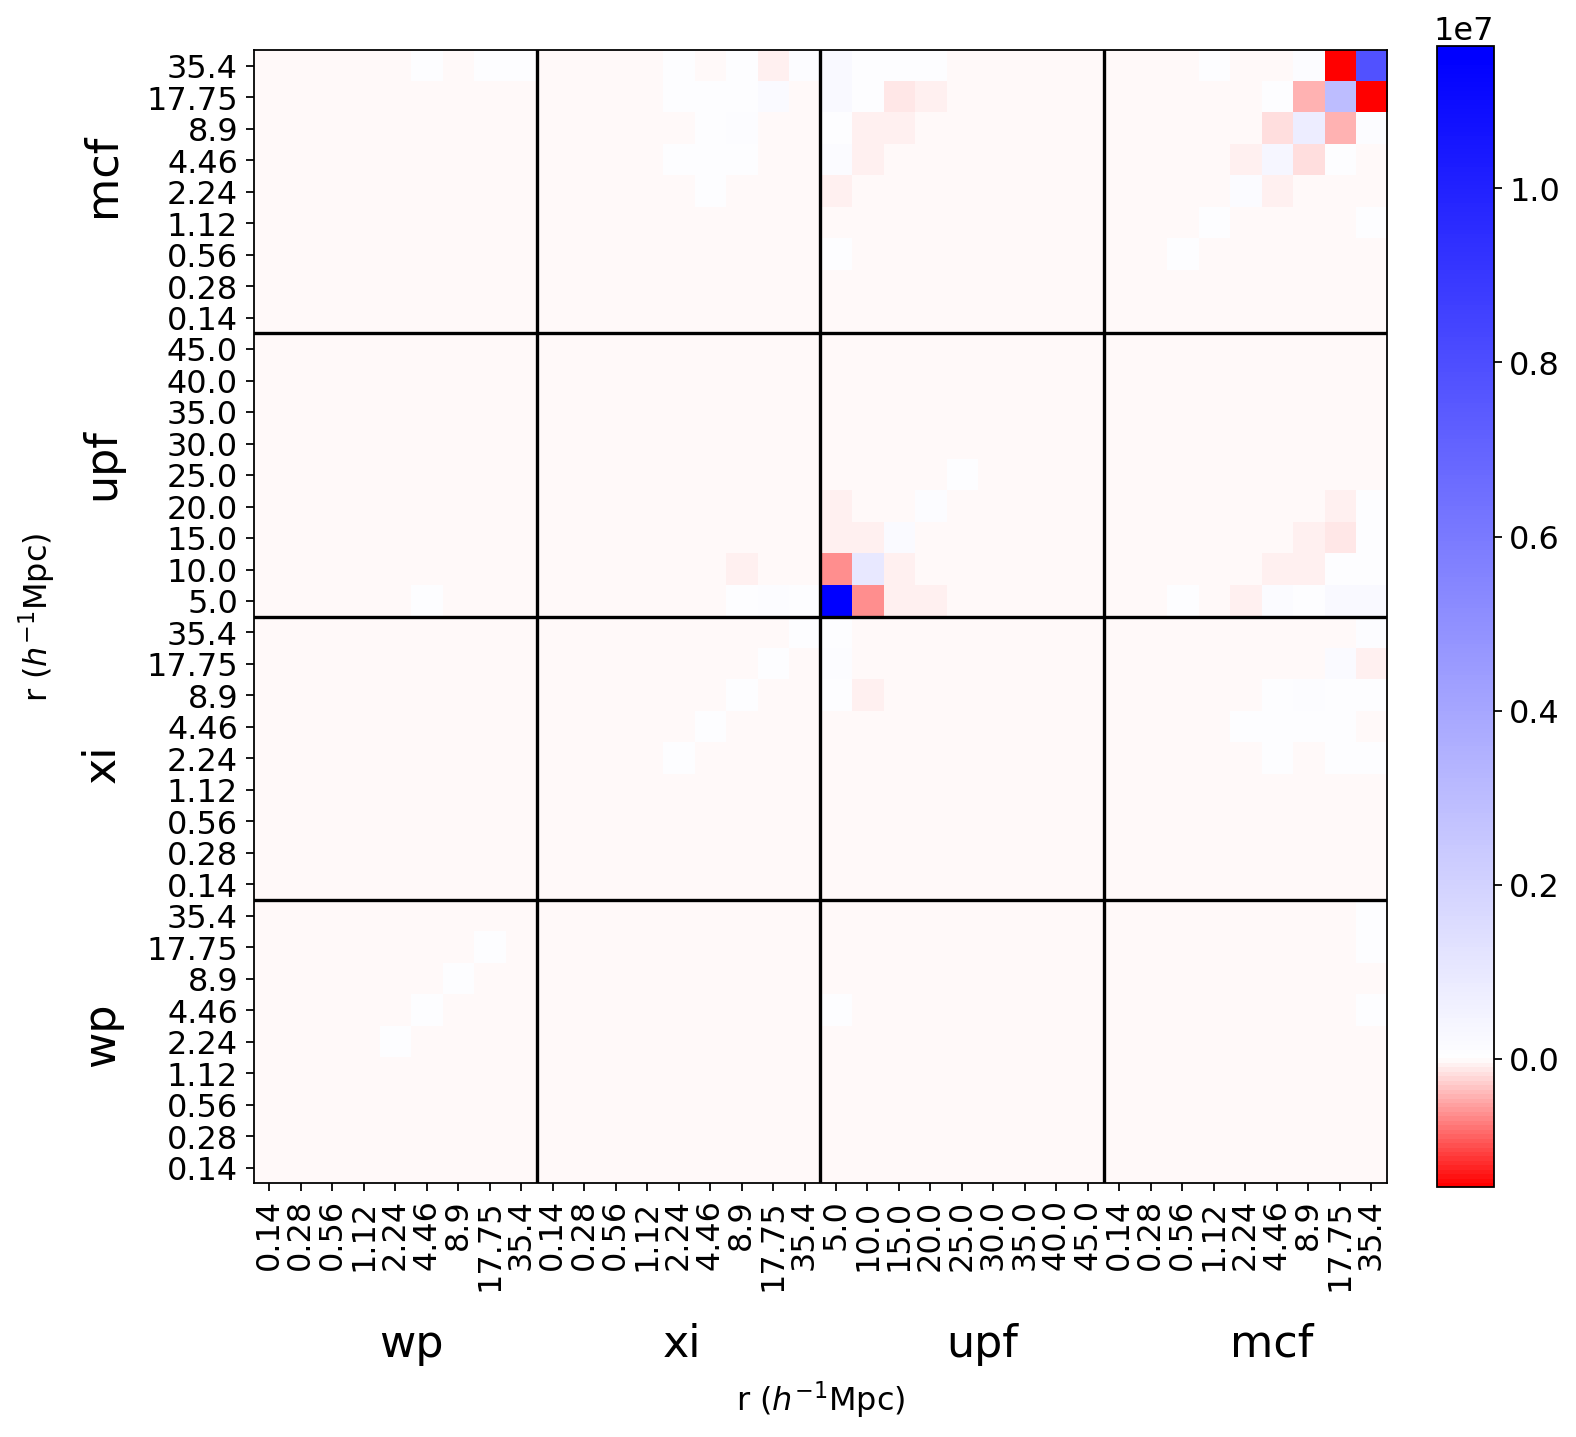

In [258]:
cov_glam = get_cov(statistics_all, 'glam')
icov_glam = np.linalg.inv(cov_glam)
plot_icov_matrix(icov_glam, statistics_all)

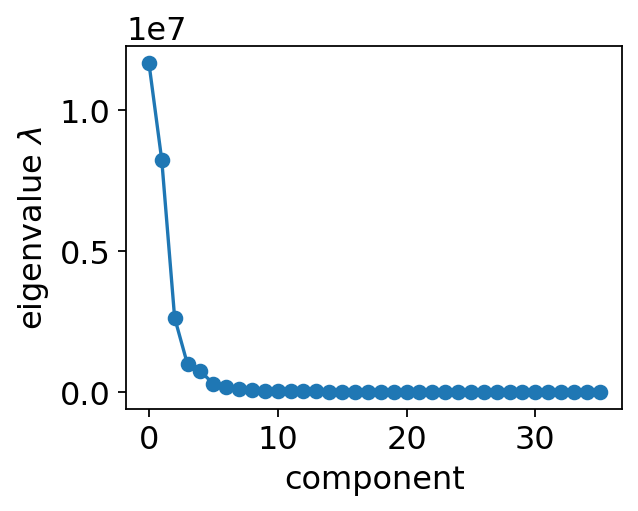

In [259]:
ax = plot_eigenvalues(icov_glam)
#ax.set_yscale('log')

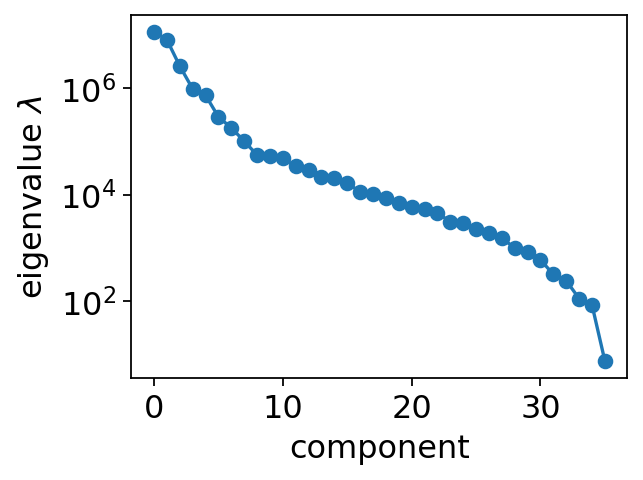

In [260]:
ax = plot_eigenvalues(icov_glam)
ax.set_yscale('log')

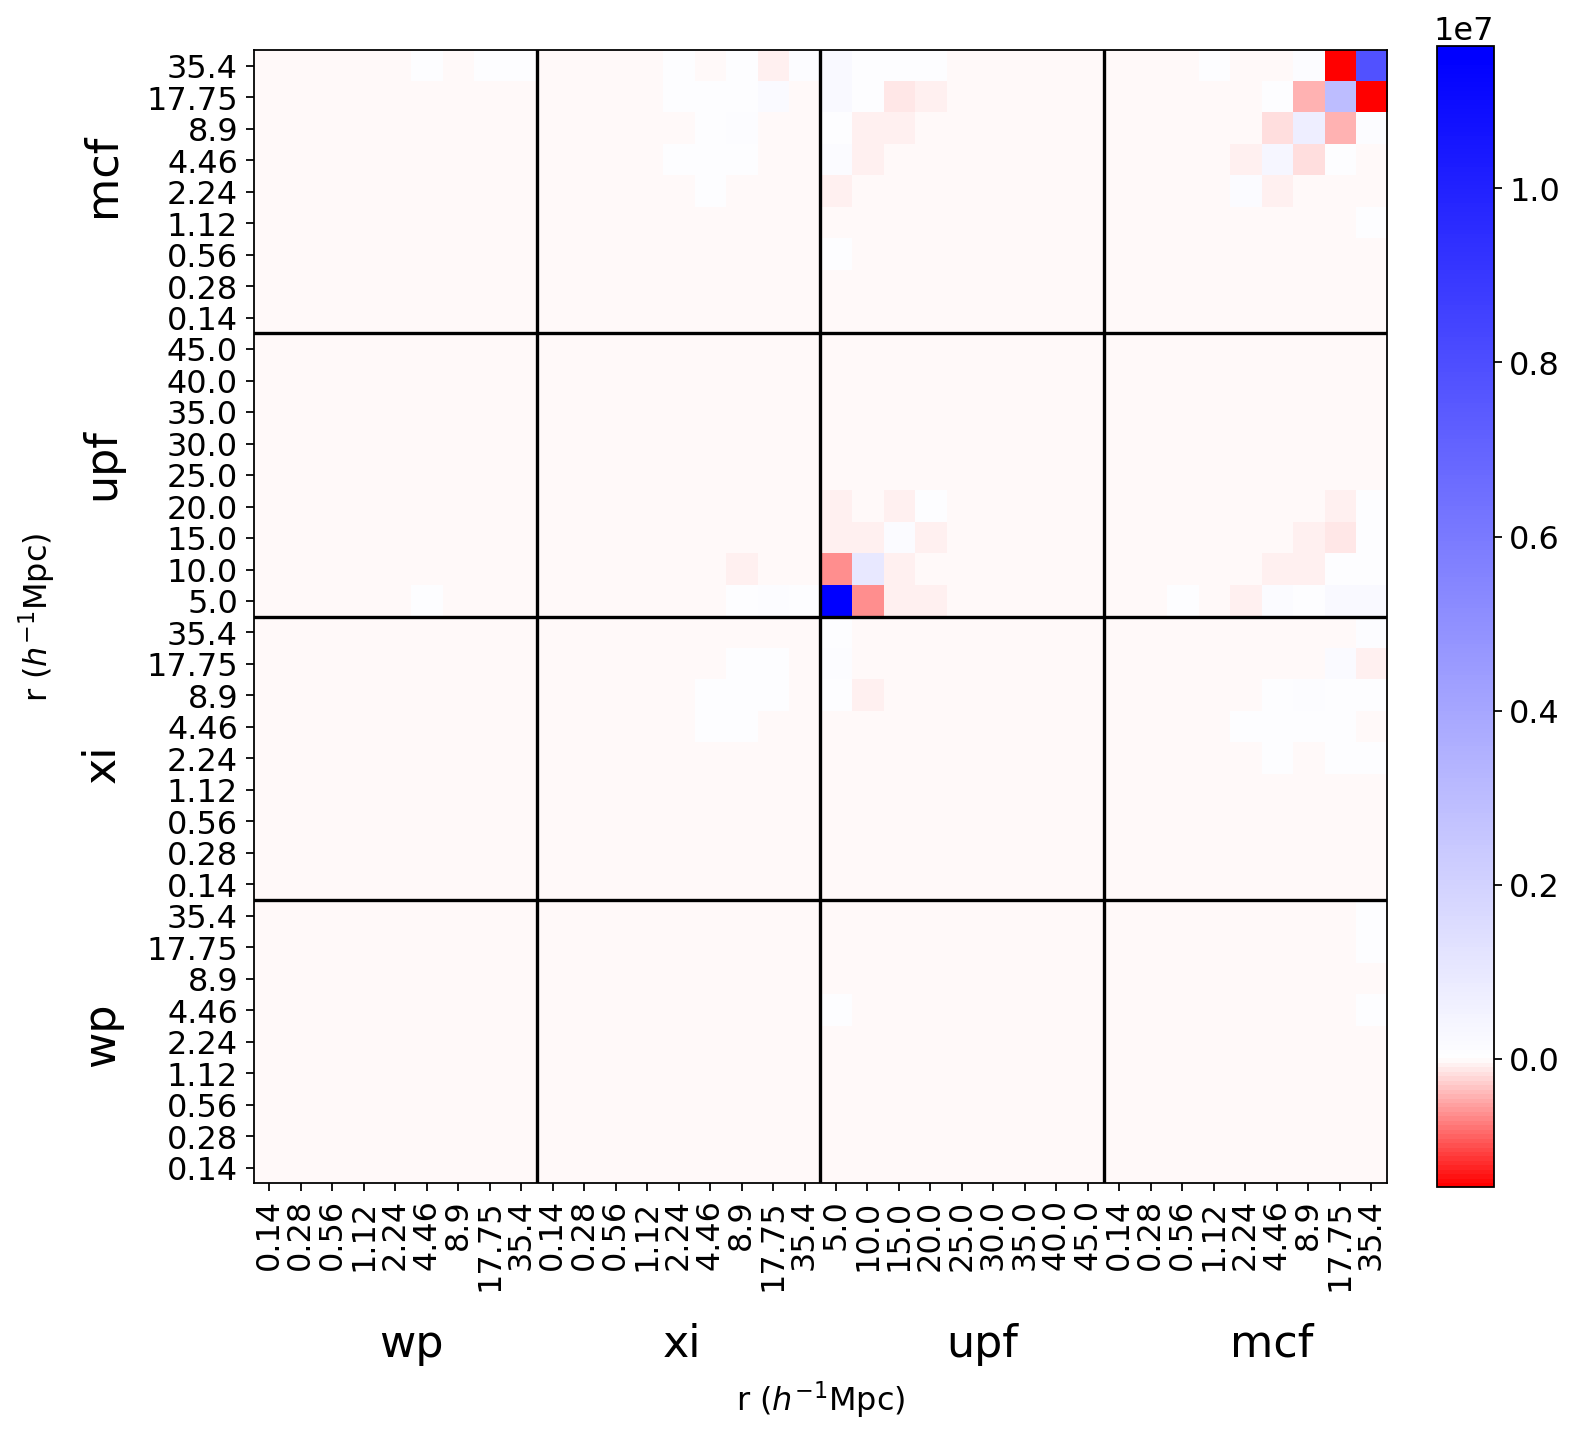

In [267]:
icov_glam_largest = eigendecomp_v2(icov_glam, 8)
plot_icov_matrix(icov_glam_largest, statistics_all)

## emu

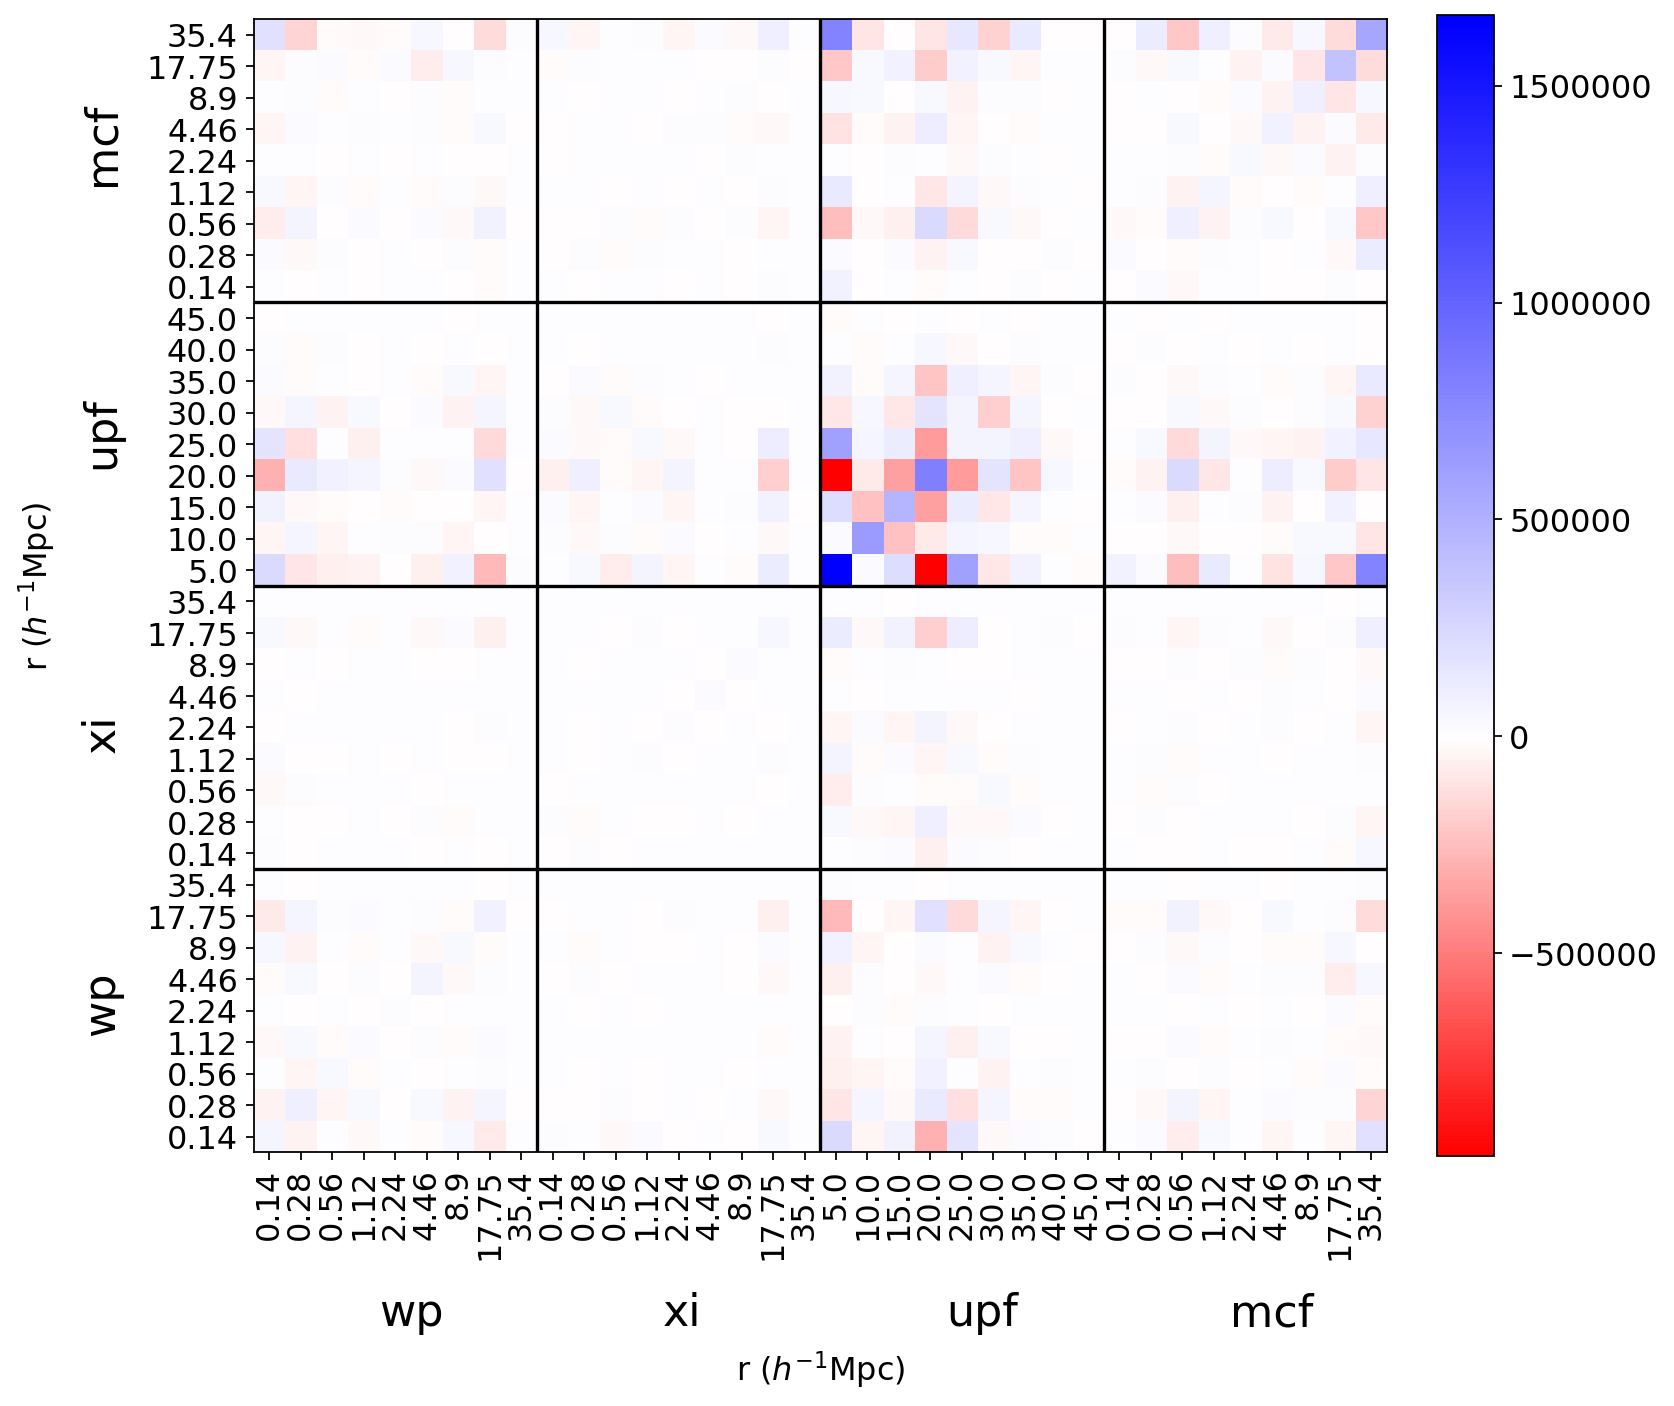

In [28]:
icov_emu = np.linalg.inv(cov_emu)
plot_icov_matrix(icov_emu, statistics_all)

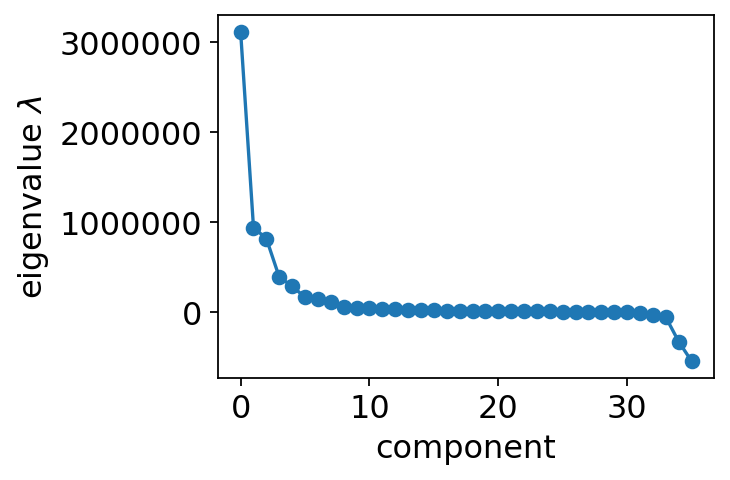

In [33]:
ax = plot_eigenvalues(icov_emu)
#ax.set_yscale('log')

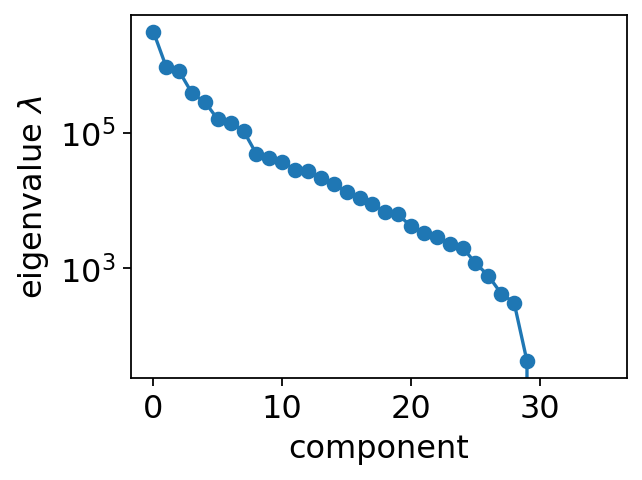

In [34]:
ax = plot_eigenvalues(icov_emu)
ax.set_yscale('log')

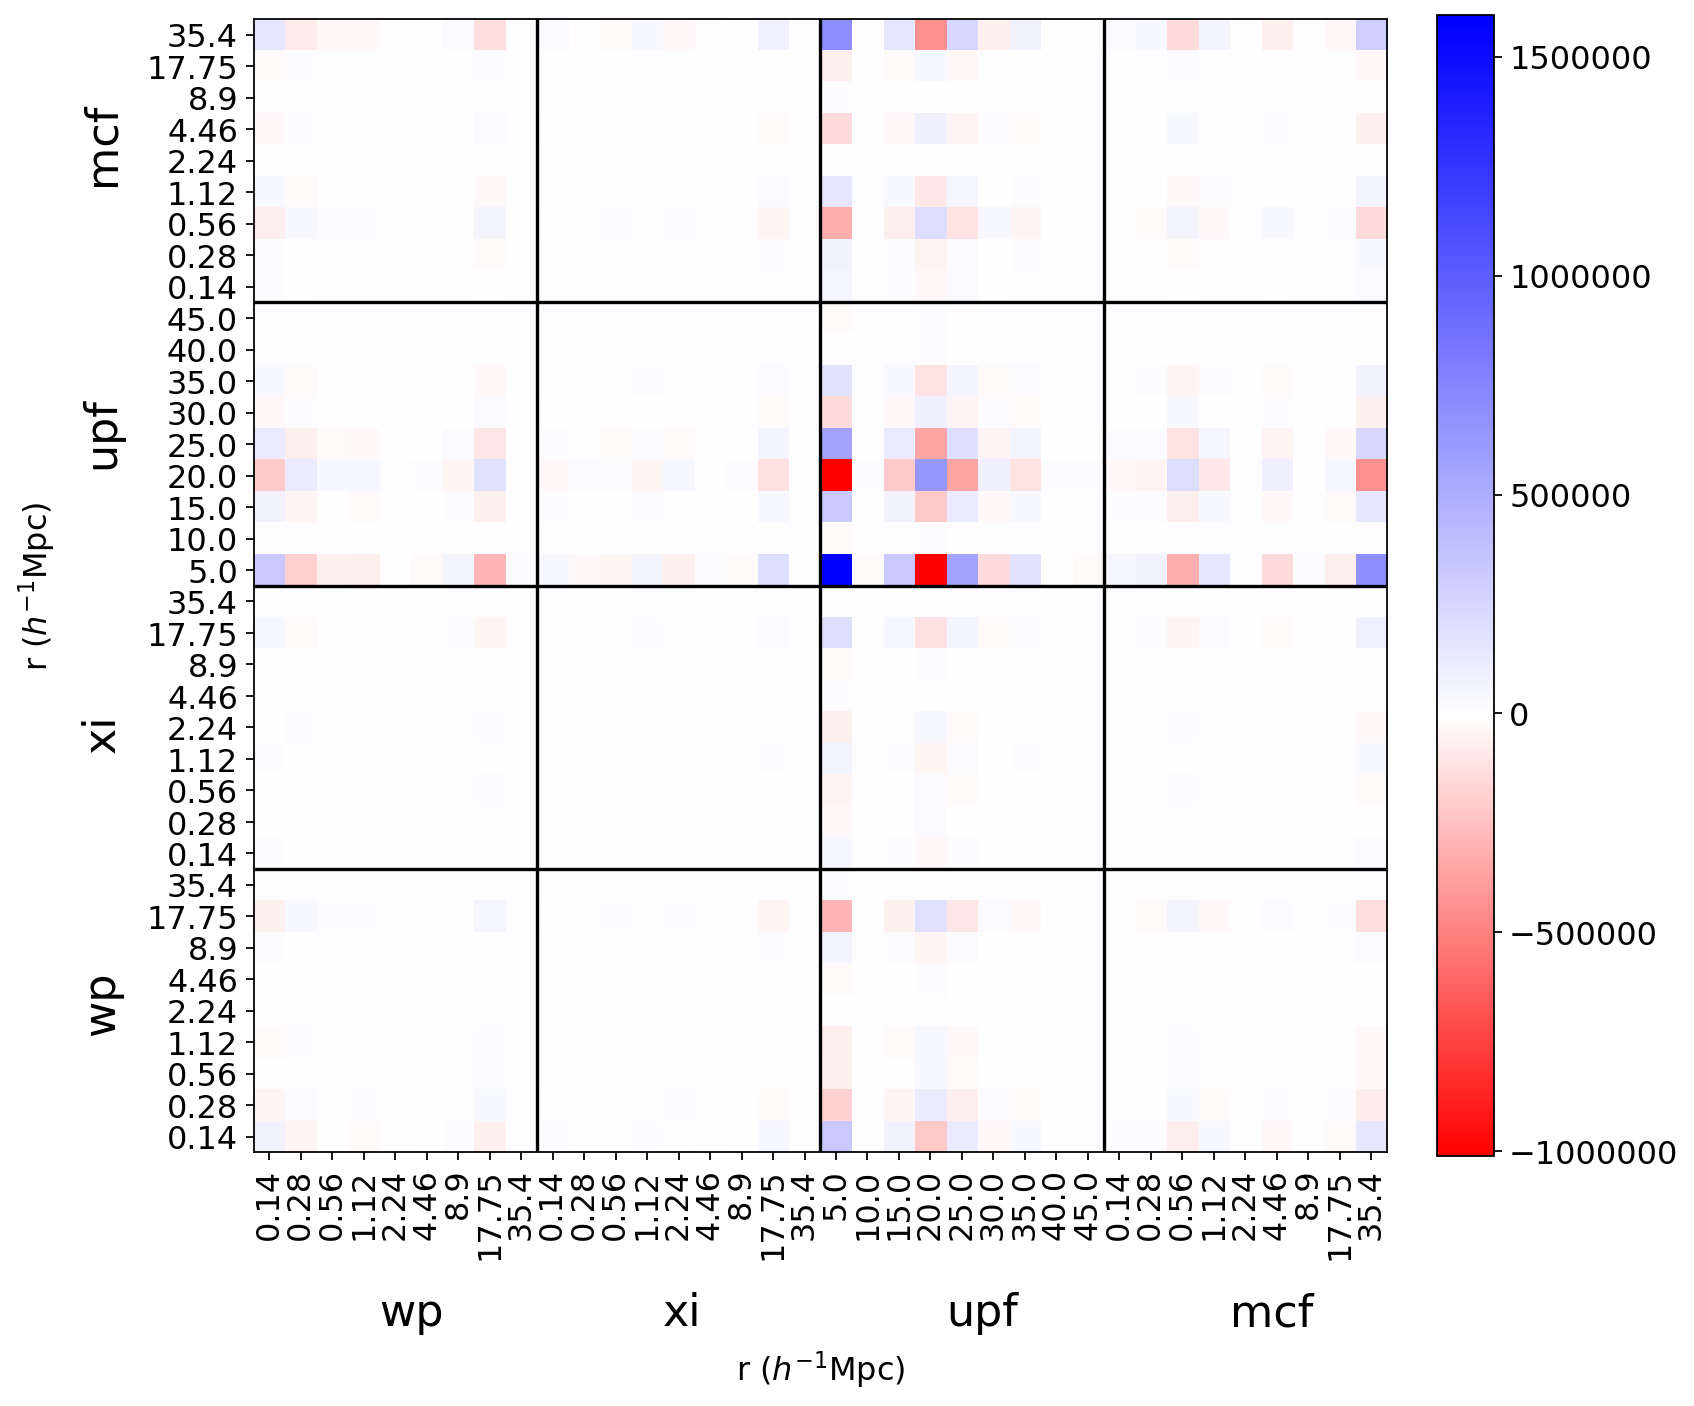

In [36]:
icov_emu_largest = eigendecomp_v2(icov_emu, 1)
plot_icov_matrix(icov_emu_largest, statistics_all)

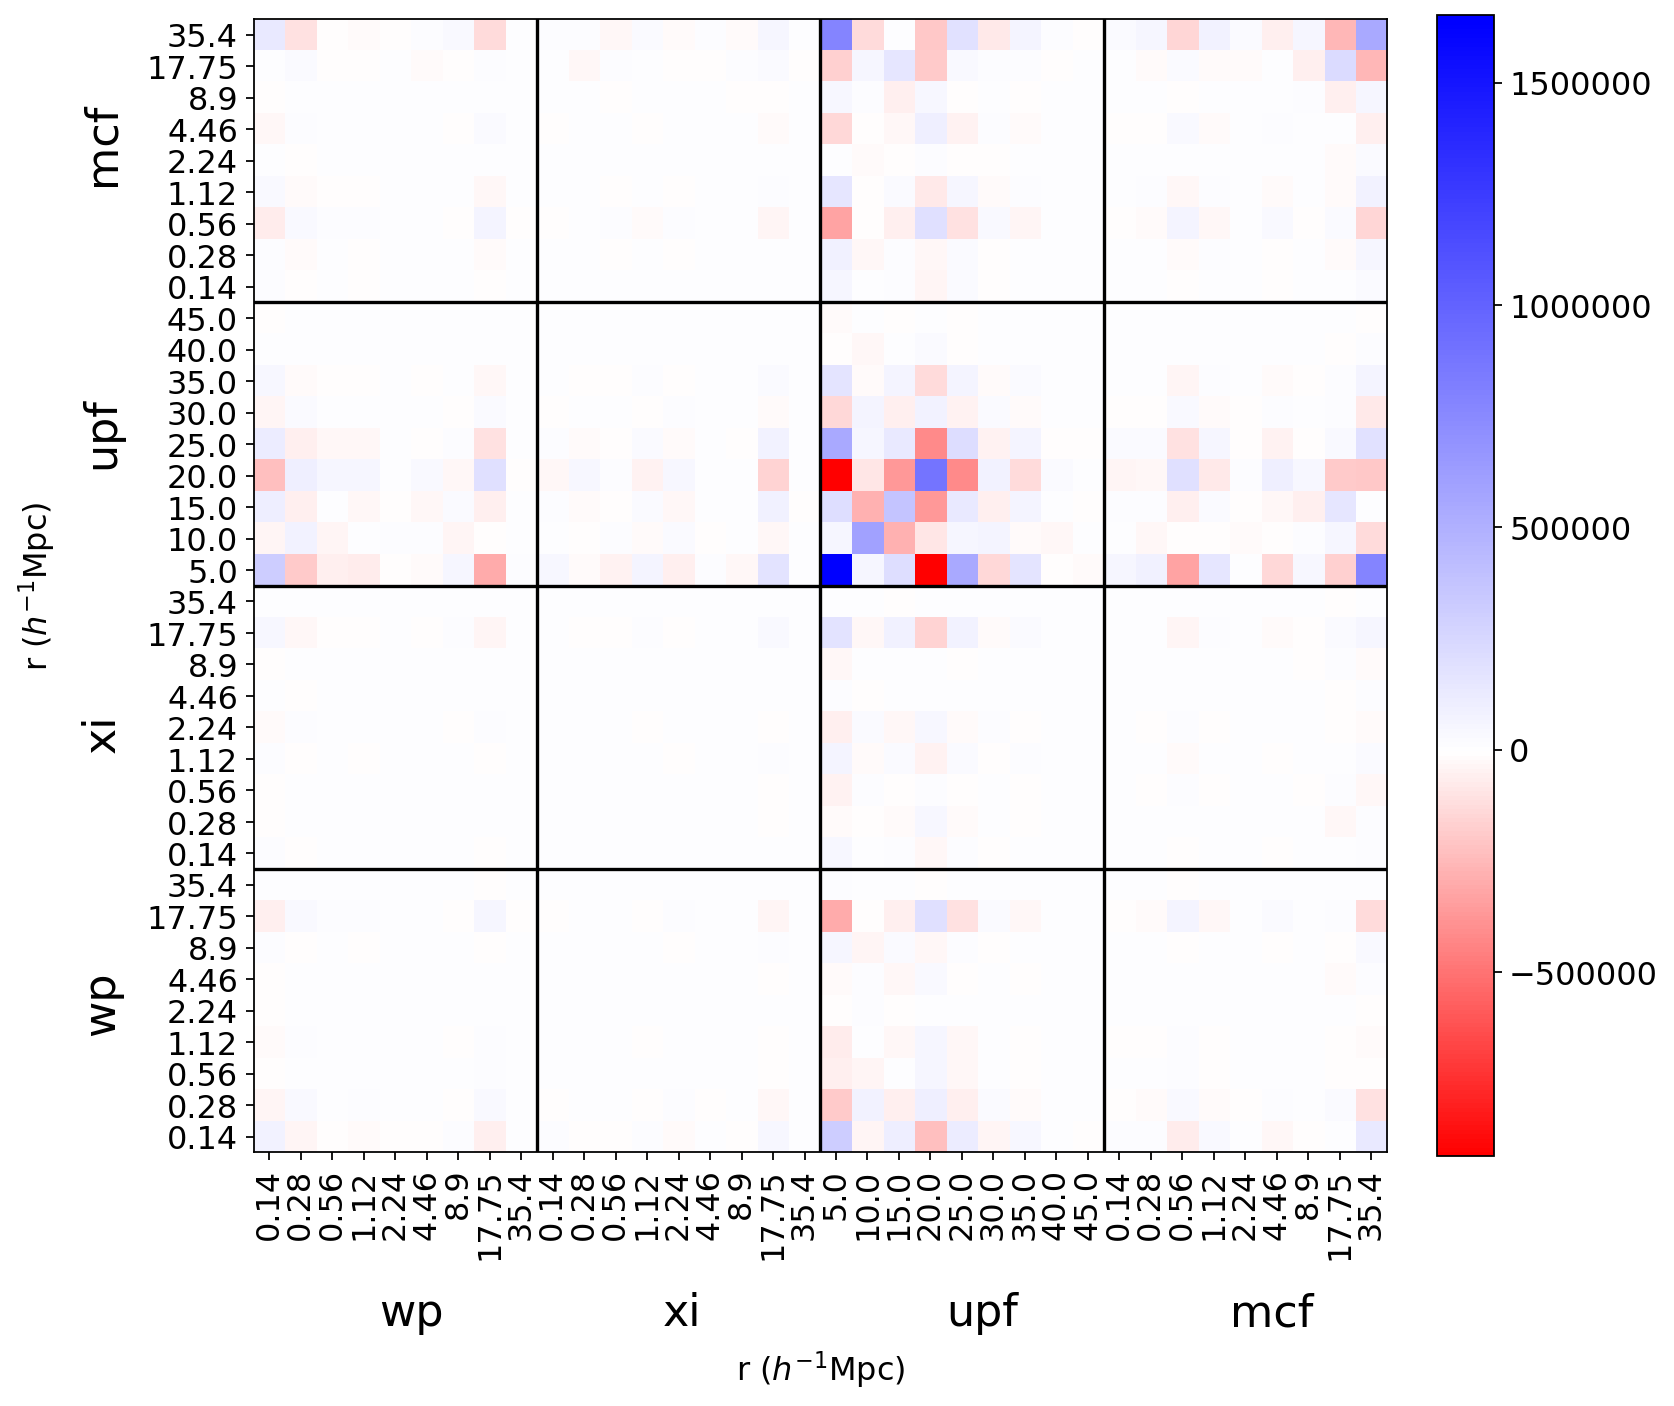

In [35]:
icov_emu_largest = eigendecomp_v2(icov_emu, 3)
plot_icov_matrix(icov_emu_largest, statistics_all)

## emu wp

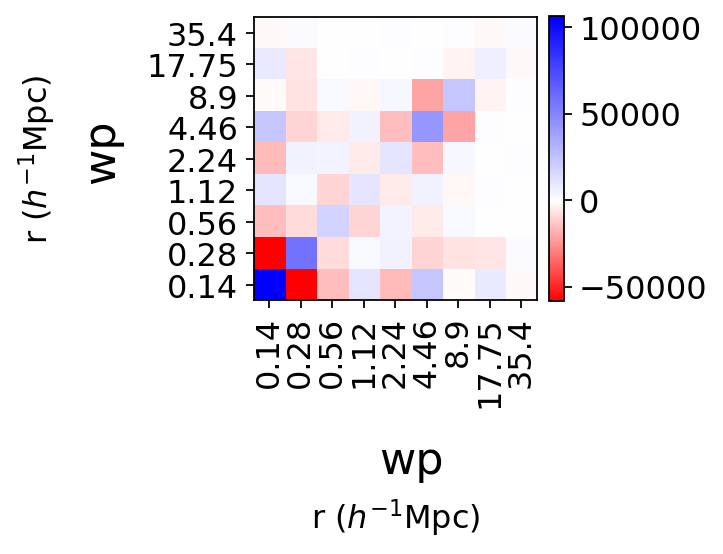

In [277]:
cov_emuperf_w = get_cov(['wp'], 'emuperf', tag_str='_nonolap_hod3_test0_mean_test0')
cov_glam_w = get_cov(['wp'], 'glam')
cov_glam_scaled_w = cov_glam_w*(1/5)*(L_glam/L_aemulus)**3
cov_emu_w = cov_emuperf_w - cov_glam_scaled_w

icov_emu_w = np.linalg.inv(cov_emu_w)
plot_icov_matrix(icov_emu_w, ['wp'])

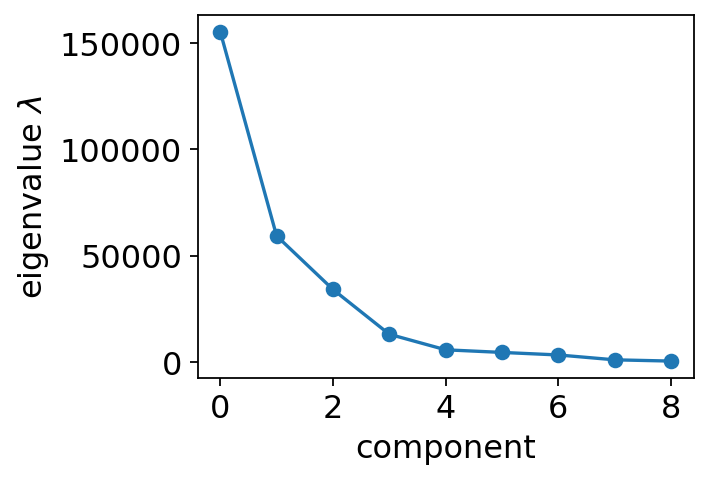

In [278]:
plot_eigenvalues(icov_emu_w)

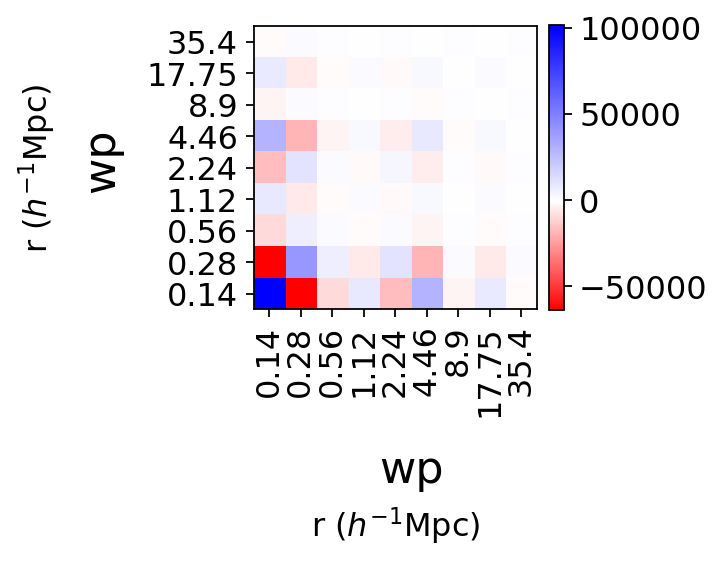

In [279]:
icov_emu_w_largest = eigendecomp_v2(icov_emu_w, 1)
plot_icov_matrix(icov_emu_w_largest, ['wp'])

## SVD on correlation matrix (via zhongxu)

In [23]:
corr = utils.reduced_covariance(cov_glam)
Nmock = 986 # number of mocks (if you are using GLAM)
u1, s1, vh1 = np.linalg.svd(corr)
v1 = vh1.T
ids_small = np.where(s1<np.sqrt(2./Nmock))[0] # Eq (20) of https://arxiv.org/pdf/astro-ph/0501637.pdf
s1_inv = 1./s1
s1_inv[ids_small] = 0.0
s1_new = np.diag(s1_inv)
icov_glam_svd = np.dot(v1, np.dot(s1_new, u1.T)) # inverse matrix

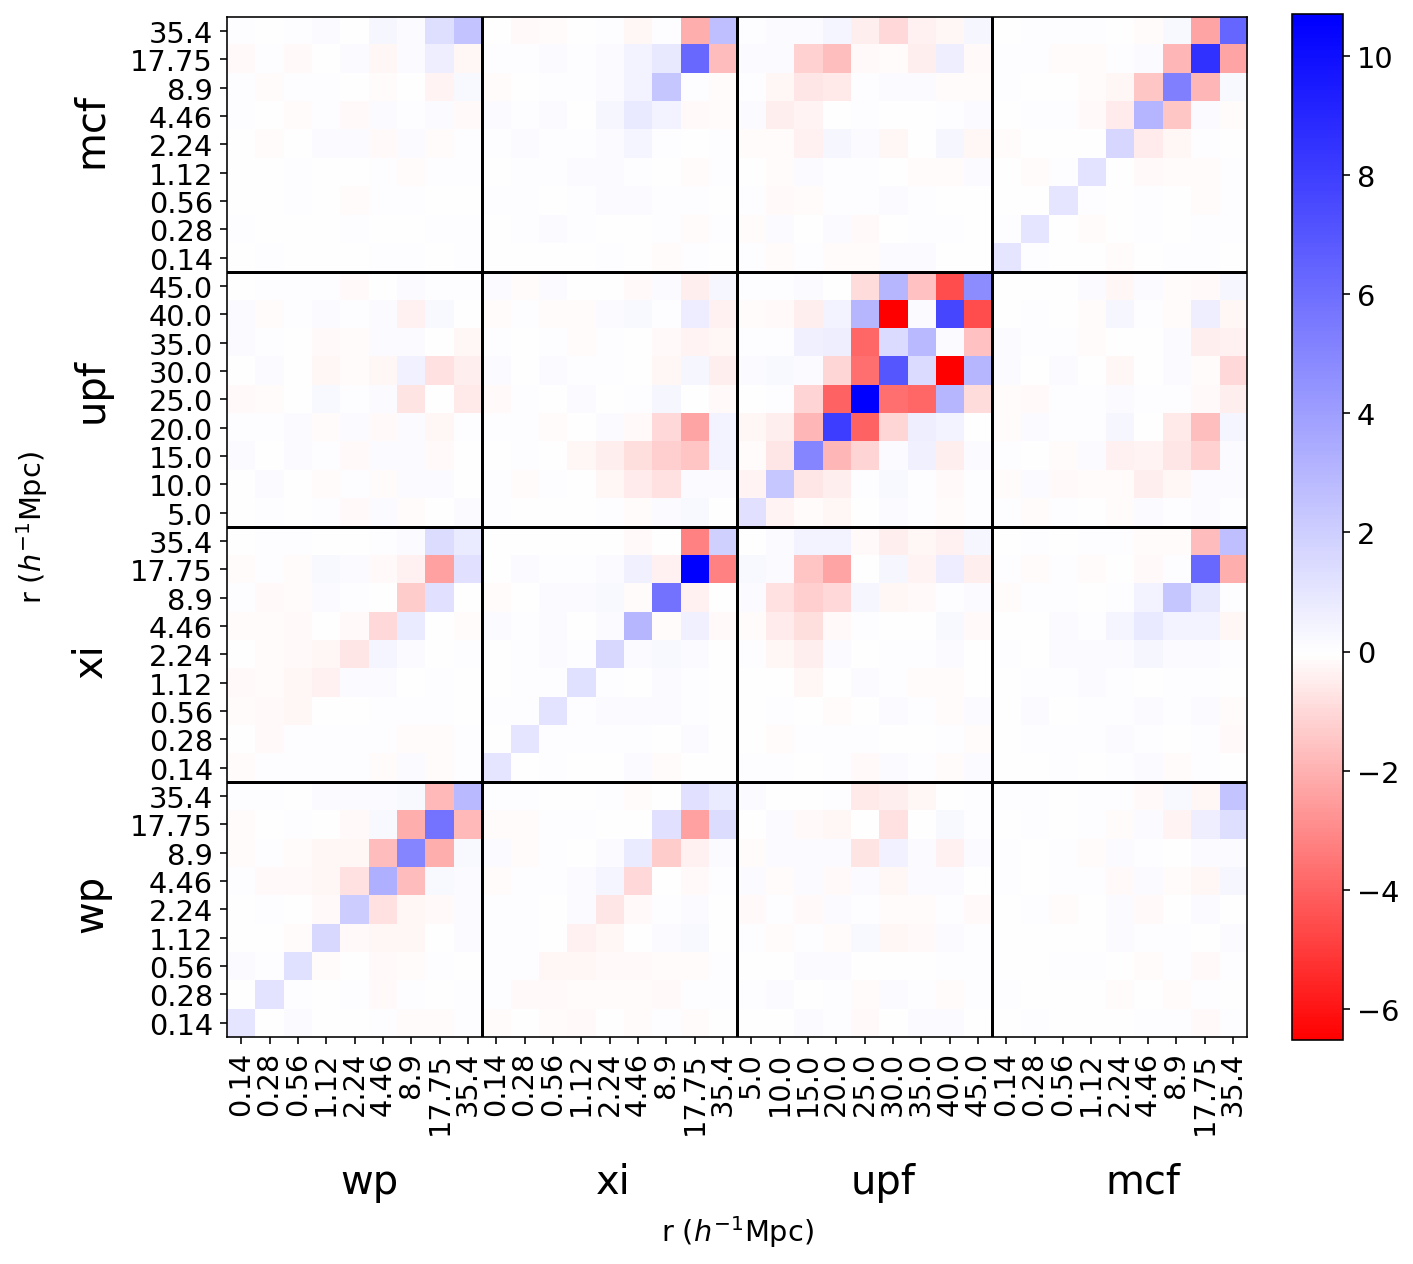

In [24]:
plot_icov_matrix(icov_glam_svd, statistics_all)

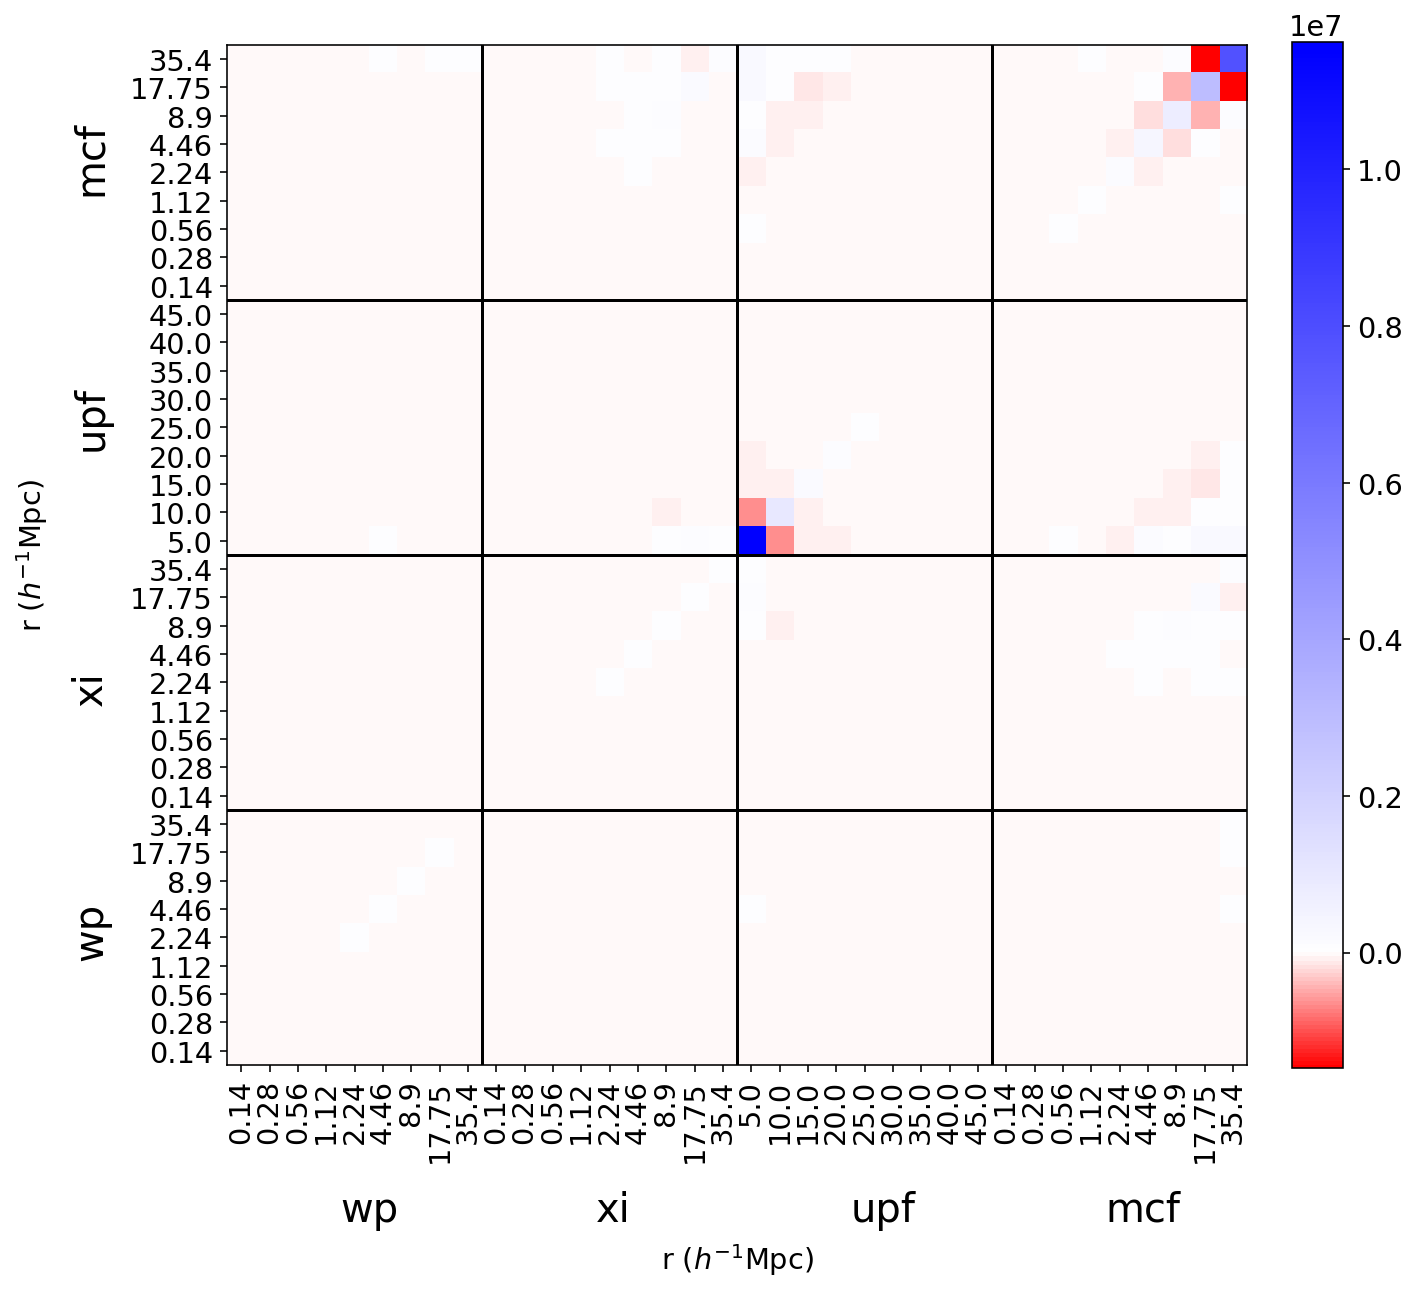

In [25]:
plot_icov_matrix(np.linalg.inv(cov_glam), statistics_all)